##### Note
Allign tables to the left

In [4]:
%%html
<style>
table {float:left}
</style>

# Evaluation of models
basic, spatial, temporal and spatial-temporal evaluation of the error terms

## Contents:
    1. Load in data and initialise the GeoDataFrame
    2. Model evaluation (basic)
    3. Feature importance from Random forest
    4. Spatial evaluation
    5. Temporal evaluation  




| Number | Purpose    |
|--------|------------|
| 0      | Leisure    |
| 1      | Food/Drink |
| 2      | Shops      |
| 3      | Pick-up/Drop-off    |
| 4      | Education |
| 5      | Health      |


In [290]:
# REQUIRED: For basic evaluation of models
import pandas as pd
import geopandas as gpd
import shapely
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec
import seaborn as sns
import numpy as np
import datetime
import sklearn.metrics

# OPTIONAL: For spatial and temporal analysis (Sections 4+5)
import pysal as ps
import esda # from pysal
import pysal.lib
import geoplot
import splot
import pointpats
import statsmodels.tsa.stattools
import statsmodels.tsa.seasonal 

%matplotlib inline


sns.set_style('white')
sns.set_context('paper')

%matplotlib inline

# 1. Load in data and turn into GeoDataFrame
In this section, we load in the prediction data and shapefiles used to plot the data.
We also define the global variables used in the notebooks

## Load in data

In [30]:
# predictions
predictions_17 = pd.read_csv('../../Data/model_outputs/predictions_17.csv')

mtl_region = gpd.read_file("../../Data/shapes/mtl_regions.json", crs='EPSG:3347')
mtl_dissem = gpd.read_file("../../Data/shapes/mtl_dissem.geojson", crs='EPSG:3347')
mtl_dissem.crs = 'EPSG:3347' # TODO: temporary work around
city_of_montreal = mtl_region.loc[(mtl_region.AIRE > 0) & (mtl_region.TYPE == 'Arrondissement')]

In [31]:
predictions_17

mode  duration    distance_m  weekday  morning  midday  afternoon  \
0        2       703   1996.287779        1        0       0          0   
1        0      2180   3807.795577        1        0       1          0   
2        0       469    315.522285        1        0       0          1   
3        2      8419  10772.782900        0        0       0          0   
4        1      4069  14644.240485        0        0       0          0   
...    ...       ...           ...      ...      ...     ...        ...   
6493     2      1076  13207.570739        1        0       0          0   
6494     5       766    157.078356        1        0       0          0   
6495     2      1165  12233.968564        1        0       1          0   
6496     0       225     68.930314        1        0       0          0   
6497     2      1446   4313.256489        1        0       0          1   

      evening  midnight  p_nearby_0  ...  p_nearby_3  p_nearby_4  p_nearby_5  \
0           1         0    0.000000  ...    0.000000    0.000000    0.000000   
1           0         0    0.057143  ...    0.085714    0.000000    0.114286   
2           0         0    0.400000  ...    0.000000    0.000000    0.133333   
3           1         0    1.000000  ...    0.000000    0.000000    0.000000   
4           0         1    0.360000  ...    0.080000    0.320000    0.040000   
...       ...       ...         ...  ...         ...         ...         ...   
6493        1         0    0.000000  ...    0.000000    0.000000    0.000000   
6494        0         1    0.503759  ...    0.000000    0.248120    0.007519   
6495        0         0    0.000000  ...    0.000000    0.000000    0.000000   
6496        0         1    0.333333  ...    0.000000    0.000000    0.000000   
6497        0         0    0.509434  ...    0.018868    0.169811    0.037736   

      id_trip  purpose  prediction            starttime              endtime  \
0       34003        2           2  2017-09-29 20:12:40  2017-09-29 20:24:23   
1      403058        2           2  2017-09-25 12:56:19  2017-09-25 13:32:39   
2      171603        0           0  2017-10-04 15:07:11  2017-10-04 15:15:00   
3      463958        0           0  2017-10-01 15:02:08  2017-10-01 17:22:27   
4      151415        3           0  2017-09-30 00:31:18  2017-09-30 01:39:07   
...       ...      ...         ...                  ...                  ...   
6493    65227        0           2  2017-10-06 19:37:32  2017-10-06 19:55:28   
6494   213603        0           0  2017-09-29 04:22:45  2017-09-29 04:35:31   
6495   323826        5           2  2017-09-18 12:25:08  2017-09-18 12:44:33   
6496   268115        2           2  2017-09-20 00:58:15  2017-09-20 01:02:00   
6497   474682        1           0  2017-10-02 15:46:38  2017-10-02 16:10:44   

            lat       long  
0     45.593352 -73.545390  
1     45.541448 -73.561588  
2     45.547618 -73.665398  
3     45.527778 -73.536887  
4     45.524721 -73.522009  
...         ...        ...  
6493  45.502399 -73.960984  
6494  45.514820 -73.565604  
6495  45.610037 -73.720401  
6496  45.545870 -73.576231  
6497  45.500431 -73.577970  

[6498 rows x 22 columns]

In [32]:
predictions_17['correct'] = predictions_17.apply(lambda row: row['purpose'] == row['prediction'], axis=1)

In [33]:
predictions_17

mode  duration    distance_m  weekday  morning  midday  afternoon  \
0        2       703   1996.287779        1        0       0          0   
1        0      2180   3807.795577        1        0       1          0   
2        0       469    315.522285        1        0       0          1   
3        2      8419  10772.782900        0        0       0          0   
4        1      4069  14644.240485        0        0       0          0   
...    ...       ...           ...      ...      ...     ...        ...   
6493     2      1076  13207.570739        1        0       0          0   
6494     5       766    157.078356        1        0       0          0   
6495     2      1165  12233.968564        1        0       1          0   
6496     0       225     68.930314        1        0       0          0   
6497     2      1446   4313.256489        1        0       0          1   

      evening  midnight  p_nearby_0  ...  p_nearby_4  p_nearby_5  id_trip  \
0           1         0    0.000000  ...    0.000000    0.000000    34003   
1           0         0    0.057143  ...    0.000000    0.114286   403058   
2           0         0    0.400000  ...    0.000000    0.133333   171603   
3           1         0    1.000000  ...    0.000000    0.000000   463958   
4           0         1    0.360000  ...    0.320000    0.040000   151415   
...       ...       ...         ...  ...         ...         ...      ...   
6493        1         0    0.000000  ...    0.000000    0.000000    65227   
6494        0         1    0.503759  ...    0.248120    0.007519   213603   
6495        0         0    0.000000  ...    0.000000    0.000000   323826   
6496        0         1    0.333333  ...    0.000000    0.000000   268115   
6497        0         0    0.509434  ...    0.169811    0.037736   474682   

      purpose  prediction            starttime              endtime  \
0           2           2  2017-09-29 20:12:40  2017-09-29 20:24:23   
1           2           2  2017-09-25 12:56:19  2017-09-25 13:32:39   
2           0           0  2017-10-04 15:07:11  2017-10-04 15:15:00   
3           0           0  2017-10-01 15:02:08  2017-10-01 17:22:27   
4           3           0  2017-09-30 00:31:18  2017-09-30 01:39:07   
...       ...         ...                  ...                  ...   
6493        0           2  2017-10-06 19:37:32  2017-10-06 19:55:28   
6494        0           0  2017-09-29 04:22:45  2017-09-29 04:35:31   
6495        5           2  2017-09-18 12:25:08  2017-09-18 12:44:33   
6496        2           2  2017-09-20 00:58:15  2017-09-20 01:02:00   
6497        1           0  2017-10-02 15:46:38  2017-10-02 16:10:44   

            lat       long correct  
0     45.593352 -73.545390    True  
1     45.541448 -73.561588    True  
2     45.547618 -73.665398    True  
3     45.527778 -73.536887    True  
4     45.524721 -73.522009   False  
...         ...        ...     ...  
6493  45.502399 -73.960984   False  
6494  45.514820 -73.565604    True  
6495  45.610037 -73.720401   False  
6496  45.545870 -73.576231    True  
6497  45.500431 -73.577970   False  

[6498 rows x 23 columns]

In [34]:
predictions_17['starttime'] = pd.to_datetime(predictions_17['starttime'])
predictions_17['endtime'] = pd.to_datetime(predictions_17['endtime'])

In [36]:
predictions_17['end_point'] = predictions_17.apply(lambda row: \
                                                     shapely.geometry.Point(row['long'],row['lat']), axis=1)

In [37]:
predictions_17_gdf = gpd.GeoDataFrame(predictions_17, geometry='end_point', crs='EPSG:4326')

In [39]:
predictions_17_gdf = predictions_17_gdf.to_crs(3347)

In [40]:
predictions_17_gdf.head()

mode  duration    distance_m  weekday  morning  midday  afternoon  evening  \
0     2       703   1996.287779        1        0       0          0        1   
1     0      2180   3807.795577        1        0       1          0        0   
2     0       469    315.522285        1        0       0          1        0   
3     2      8419  10772.782900        0        0       0          0        1   
4     1      4069  14644.240485        0        0       0          0        0   

   midnight  p_nearby_0  ...  p_nearby_5  id_trip  purpose  prediction  \
0         0    0.000000  ...    0.000000    34003        2           2   
1         0    0.057143  ...    0.114286   403058        2           2   
2         0    0.400000  ...    0.133333   171603        0           0   
3         0    1.000000  ...    0.000000   463958        0           0   
4         1    0.360000  ...    0.040000   151415        3           0   

            starttime             endtime        lat       long correct  \
0 2017-09-29 20:12:40 2017-09-29 20:24:23  45.593352 -73.545390    True   
1 2017-09-25 12:56:19 2017-09-25 13:32:39  45.541448 -73.561588    True   
2 2017-10-04 15:07:11 2017-10-04 15:15:00  45.547618 -73.665398    True   
3 2017-10-01 15:02:08 2017-10-01 17:22:27  45.527778 -73.536887    True   
4 2017-09-30 00:31:18 2017-09-30 01:39:07  45.524721 -73.522009   False   

                         end_point  
0  POINT (7630490.593 1255029.541)  
1  POINT (7630922.478 1249052.437)  
2  POINT (7622834.509 1247391.125)  
3  POINT (7633237.884 1248130.151)  
4  POINT (7634466.879 1248134.941)  

[5 rows x 24 columns]

### Global Variables
Define variables which are used in multiple places

In [42]:
## for converting purpose factor number back to purpose name
PURPOSE_CLASSES = {0:'leisure', 1:'food_drink', 2:'shops', 3:'pick_up_drop_off',  4:'education', 5:'health'}
LONG_NAMES = ['Leisure','Food & drink','Shopping','Pick-up/drop-off','Education','Health']
SHORT_NAMES = ['Leisure','Food','Shop','P.u./D.o.','Education','Health']

## for plotting Montreal
MIN_LON = predictions_17.long.min() - 1000
MAX_LON = predictions_17.long.max() + 1000
MIN_LAT = predictions_17.lat.min() - 1000
MAX_LAT = predictions_17.lat.max() + 1000

## for general plotting
COLOUR_MAP = 'Blues'
COLOURBLIND_PALETTE = ["#7b85d4","#f37738","#83c995","#d7369e","#c4c9d8","#859795","#e9d043","#ad5b50", "#ffa07a", "k"]
MARKER_TYPES = ['s','o', '*']

## true and prediction labels
TRUE_LABELS = predictions_17['purpose']
PREDICTION_LABELS = predictions_17['prediction']

# observed accuracy == our model's accuracy
OBSERVERD_ACCURACY = sklearn.metrics.accuracy_score(PREDICTION_LABELS, TRUE_LABELS)
print("Accuracy =", OBSERVERD_ACCURACY)

Accuracy = 0.546321945213912


# 2. Basic model evaluation
In this section, we carry out non-spatial and non-temporal evaluation of the model. We explore the failures of the model for each class

### Contents:
    2.1. Confusion matrix  
    2.2. Stacked bar charts  
    2.3. Evaluation statistics
    
#### Other ideas:
    2.4. Multi-class Precision-recall curves

  
References:  
https://medium.com/apprentice-journal/evaluating-multi-class-classifiers-12b2946e755b

## 2.1 Confusion matrix
Visualisation of a confusion matrix of the predictions

In [43]:
def plot_confusion_matrix(conf_matrix, mpl_kwargs):
    """
        function for plotting a confusion matrix as a heatmap
        -------------------------
        :params conf_matrix: (N*N numpy.array) Confusion matrix to plot
        :return ax: (matplotlib.pyplot.figure.axes) the axes of the figure so it can be saved as an image or edited
    """
    # plot this confusion matrix 
    fig, ax = plt.subplots(1,figsize=(9,7))
    # main plot
    sns.heatmap(conf_matrix, annot=True, annot_kws={'size':14}, **mpl_kwargs)
    # styling
    plt.xticks(np.arange(len([0,1,2,3,4,5]))+0.5, labels=SHORT_NAMES, size=14);
    plt.yticks(np.arange(len([0,1,2,3,4,5]))+0.5, labels=SHORT_NAMES, size=14, va='center');
    plt.xlabel('Predicted',size=20)
    plt.ylabel('Actual',size=20)
    ax.figure.axes[-1].yaxis.label.set_size(20)
    ax.figure.axes[-1].set_yticklabels(ax.figure.axes[-1].get_yticklabels(),fontsize=14);
    plt.title('Random forest estimation of trip purpose', size=20)
    return ax

In [44]:
# create a confusion matrix using sklearn
conf_matrix = sklearn.metrics.confusion_matrix(TRUE_LABELS, PREDICTION_LABELS)
conf_matrix

array([[1565,   57,  556,   30,   66,   12],
       [ 357,   89,  288,    5,   31,    7],
       [ 620,   72, 1308,   25,   44,   20],
       [ 172,   16,  123,   56,   22,    4],
       [  96,   11,   66,   15,  498,    6],
       [  88,   10,   97,    7,   25,   34]])

In [45]:
## create a confusion matrix as a proportion of the actual values
# calculate the ground truths for each column (number of trips for each class) in a format that allows numpy array calculation
ground_truth_values = np.array([sum(row) for row in conf_matrix]).reshape(-1,1)
proportion_of_ground_truth = conf_matrix / ground_truth_values

In [46]:
proportion_of_ground_truth

array([[0.68460192, 0.02493438, 0.2432196 , 0.01312336, 0.02887139,
        0.00524934],
       [0.45945946, 0.11454311, 0.37065637, 0.00643501, 0.03989704,
        0.00900901],
       [0.29679272, 0.03446625, 0.62613691, 0.01196745, 0.02106271,
        0.00957396],
       [0.43765903, 0.04071247, 0.3129771 , 0.14249364, 0.05597964,
        0.01017812],
       [0.13872832, 0.01589595, 0.09537572, 0.0216763 , 0.71965318,
        0.00867052],
       [0.33716475, 0.03831418, 0.37164751, 0.02681992, 0.09578544,
        0.1302682 ]])

<ipython-input-43-2754e462bfd4>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.figure.axes[-1].set_yticklabels(ax.figure.axes[-1].get_yticklabels(),fontsize=14);


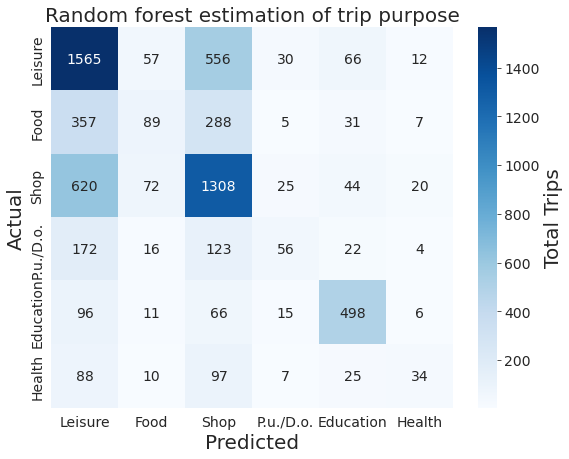

In [47]:
# define the plot styling and specifications
plot_specs = {'cbar_kws':{'label': 'Total Trips'}, 'fmt':'.0f', 'cmap':COLOUR_MAP}

# plot 
ax = plot_confusion_matrix(conf_matrix, mpl_kwargs=plot_specs)

##### Interpretation
    o For every combination of Actual/Predicted there are at least 3 trips
    o For each class the majority predicted is the actual
    o More Shopping trips are misclassified as Health trips compared to all other classes
    o Misclassified Food, Pick-up/drop-off, Education & Health trips are roughly split evenly between Leisure & Shopping trips


<ipython-input-43-2754e462bfd4>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.figure.axes[-1].set_yticklabels(ax.figure.axes[-1].get_yticklabels(),fontsize=14);


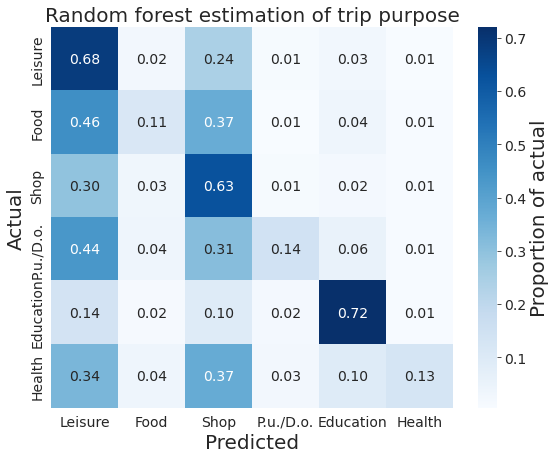

In [48]:
# define the plot styling and specifications
plot_specs = {'cbar_kws':{'label': 'Proportion of actual'}, 'fmt':'.2f', 'cmap':COLOUR_MAP}
# plot
ax = plot_confusion_matrix(proportion_of_ground_truth, mpl_kwargs=plot_specs)

##### Interpretation
    o Leisure and Shoping trips make up a highest relative proportion of the misclassified trips for all the classes. 
    o Education trips are not highly coupled with any other type of trip purpose.
    o Health, Pick-up/drop-off & Food are the 3rd most predicted class after Shops & Leisure trips in each of their respective classes (suggesting class-imbalance may have thrown the model).

## 2.2 Stacked bar charts

In [49]:
def plot_stacked_bar_chart(prediction_matrix, ylabel):
    """
        Function for plotting a stacked bar chart from a list of lists.
        The prediction matrix input will be like: [[first_class_values], [second_class_values]] 
        where first_class_values and second_class_values are lists containing the same amount of numbers
        --------------------
        :params prediction_matrix: (list of lists) a matrix to build the stacked bar chart from
        :params y_label: (string) label for the ylabel of the plot
        :return ax: (matplotlib.pyplot.figure.axes) the axes of the figure so it can be saved as an image or edited
    """
    N = prediction_matrix.shape[0]
    fig, ax = plt.subplots(1, figsize=(8,6))
    ind = np.arange(N)    # the x locations for the groups
    bottom_values = np.array([0.0,0.0,0.0,0.0,0.0,0.0])
    width=0.75
    for cls_i in range(0, N):
        prop_pred = tuple(prediction_matrix[cls_i])
        if cls_i == 0:
            plt.bar(ind, prop_pred, width=width, color=COLOURBLIND_PALETTE[cls_i])
        else:
            plt.bar(ind, prop_pred, width=width, bottom=bottom_values,color=COLOURBLIND_PALETTE[cls_i])
        bottom_values += prop_pred

    # styling
    plt.xticks(size=16)
    plt.yticks(size=16)
    ax.set_xticklabels(['']+SHORT_NAMES)
    ax.set_xlabel('Prediction', size=20)
    ax.set_ylabel('Actual (%)', size=20)
    ax.set_title("Predictions by class", size=20)
    plt.legend(LONG_NAMES,fontsize=16, loc=(1.04,0.4));
    return ax

<ipython-input-49-c81b800b0944>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+SHORT_NAMES)


<AxesSubplot:title={'center':'Predictions by class'}, xlabel='Prediction', ylabel='Actual (%)'>

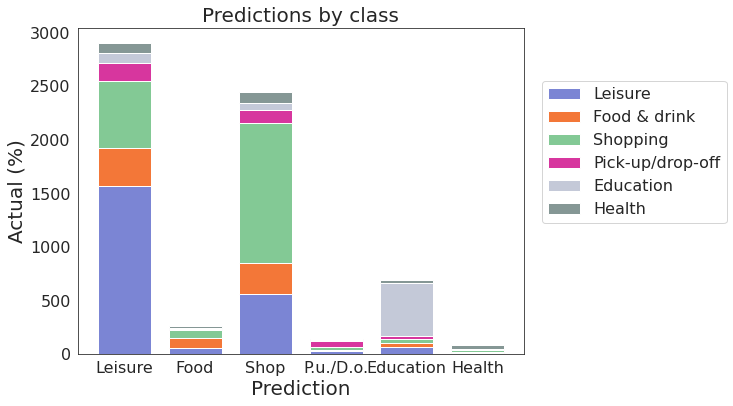

In [50]:
# plot all values
plot_stacked_bar_chart(conf_matrix, ylabel='Actual')

In [51]:
# plot the percentage of each prediction for each class
percentage_prediction_by_class = proportion_of_ground_truth.T * 100
percentage_prediction_by_class

array([[68.46019248, 45.94594595, 29.67927238, 43.76590331, 13.87283237,
        33.7164751 ],
       [ 2.49343832, 11.45431145,  3.44662518,  4.07124682,  1.58959538,
         3.83141762],
       [24.32195976, 37.06563707, 62.61369076, 31.29770992,  9.53757225,
        37.16475096],
       [ 1.31233596,  0.64350064,  1.19674485, 14.24936387,  2.16763006,
         2.68199234],
       [ 2.88713911,  3.98970399,  2.10627094,  5.59796438, 71.96531792,
         9.57854406],
       [ 0.52493438,  0.9009009 ,  0.95739588,  1.0178117 ,  0.86705202,
        13.02681992]])

In [52]:
predictions_17_gdf['purpose'].value_counts()

0    2286
2    2089
1     777
4     692
3     393
5     261
Name: purpose, dtype: int64

<ipython-input-49-c81b800b0944>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+SHORT_NAMES)


<AxesSubplot:title={'center':'Predictions by class'}, xlabel='Prediction', ylabel='Actual (%)'>

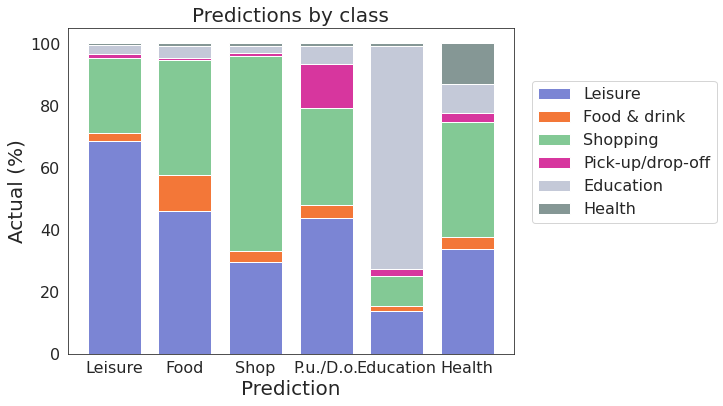

In [53]:
# plot the percentage
plot_stacked_bar_chart(percentage_prediction_by_class, ylabel='Actual (%)')

##### Interpretation
Similar interpretation to the confusion matrix, although here we can clearly see the dominance of Leisure & Shopping trip predictions in all classes other than Education.

## 2.3 Evaluation statistics
Statistics used to evaluate the model's performance

    2.3.1 F1 score, precision & recall
    2.3.2 Cohen's Kappa
    2.3.3 Mathews Correlation Coefficient (MCC)



### 2.3.1 F1 score, precision & recall
Visualise these scores

In [54]:
classification_report = sklearn.metrics.classification_report(TRUE_LABELS, PREDICTION_LABELS, output_dict=True)
classification_report_df = pd.DataFrame.from_dict(classification_report).T

In [55]:
classification_report_df

precision    recall  f1-score      support
0              0.540028  0.684602  0.603781  2286.000000
1              0.349020  0.114543  0.172481   777.000000
2              0.536505  0.626137  0.577866  2089.000000
3              0.405797  0.142494  0.210923   393.000000
4              0.725948  0.719653  0.722787   692.000000
5              0.409639  0.130268  0.197674   261.000000
accuracy       0.546322  0.546322  0.546322     0.546322
macro avg      0.494489  0.402949  0.414252  6498.000000
weighted avg   0.522499  0.546322  0.516478  6498.000000

In [56]:
precisions = classification_report_df['precision'][:6]
recalls = classification_report_df['recall'][:6]
f1_scores = classification_report_df['f1-score'][:6]

supports = classification_report_df['support'][:6]

key_values = [precisions, recalls, f1_scores]

In [61]:
def plot_classification_report(values, bar=False):
    """
        Plot values from the classification report
        :params values: (list of lists) scores from the classification for each class. Needs each list needs contain scores for each of the classes.
        :return ax: (matplotlib.pyplot.figure.axes) the axes of the figure so it can be saved as an image or edited
    """
    fig, ax = plt.subplots(1, figsize=(10,5))
    if not type(values) == list:
        values  = list(values)
    print(values[0])
    # plot either a bar or line
    if bar:
        # plot bar
        pd.DataFrame(values).T.plot.bar(ax=ax, color=COLOURBLIND_PALETTE)
    else:
        # plot line
        counter = 0
        for val in values:
            val.plot(ax=ax, color=COLOURBLIND_PALETTE[counter], marker=MARKER_TYPES[counter])
            counter += 1
#     ax.legend(fontsize=16, loc=(1.04,0.4))
    ax.legend(fontsize=15, loc='upper left', ncol=3, fancybox=True)
    plt.xlim(-0.2,5.2)
#     ax.set_xticklabels(SHORT_NAMES, size=18)
    plt.xticks([0,1,2,3,4,5],labels=SHORT_NAMES, size=18)
    plt.yticks(size=16)
    plt.xlabel('Purpose',size=18)
    plt.ylabel('Score',size=18)
    plt.ylim(0,1)
    return ax
        

0    0.540028
1    0.349020
2    0.536505
3    0.405797
4    0.725948
5    0.409639
Name: precision, dtype: float64


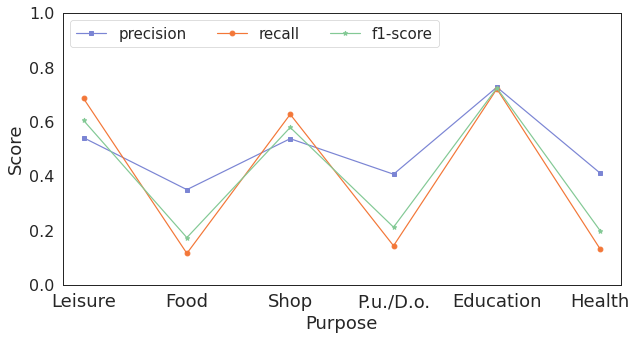

In [65]:
sns.set_style('white')
sns.set_context('paper')
plot_classification_report(key_values, bar=False)
# plt.savefig('../../other/images/model_eval_scores.png', bbox_inches='tight')

##### Interpretation
    o Relatively higher precision of Food, Pick-up and Health trips than recall. Especially for Health trips
 

### 2.3.2 Cohen's Kappa
Statistic comparing observed accuracy (i.e. our model predictions) vs expected accuracy (i.e. random chance)

Kappa = (observed accuracy - expected accuracy)/(1 - expected accuracy)

See: https://stats.stackexchange.com/questions/82162/cohens-kappa-in-plain-english

In [66]:
def calc_expected_accuracy(conf_matrix):
    """
        Make predictions based on a random classification
        
        expected_accuracy = (sum(( ground_truth_i * prediction_i ) /  total_values )) / total_values

        where: 
            _i = each class
            ground_truth == number of actual values of that class (sum of a row of the confusion matrix)
            prediction == number of prediction values of that class (sum of a columns of the confusion matrix)
            total_values == number of total values of any c;ass
        -------------------------
        :params conf_matrix: (list of lists) The confusion matrix calculated from sklearn
        :return expected_accuracy: (float) the expected accuracy from a random classification
    """
    # calculate the total amount of values
    total_values = conf_matrix.sum()
    num_rows = conf_matrix.shape[0]
    
    # calculate the total amount of values of each class
    ground_truths = [sum(row) for row in conf_matrix]

    # calculate the total amount of predictions of each class
    predictions = sum(conf_matrix)
    
    # carry out 
    expected_accuracy = 0
    for row in range(0, num_rows):
        expected_accuracy += (ground_truths[row] * predictions[row]) / total_values
    expected_accuracy = expected_accuracy / total_values
    return expected_accuracy

In [67]:
expected_accuracy = calc_expected_accuracy(conf_matrix)
print("Expected Accuracy", expected_accuracy)

Expected Accuracy 0.2952480300068179


In [68]:
print('Observed Accuracy', OBSERVERD_ACCURACY)

Observed Accuracy 0.546321945213912


In [69]:
# useful when comparing predictions to random set of predictions 
kappa_statistic = (OBSERVERD_ACCURACY - expected_accuracy) / (1 - expected_accuracy)
print("Kappa Statistic =", kappa_statistic)

Kappa Statistic = 0.3562585503798209


In [70]:
## LATE REVISION: SAME AS ->
sklearn.metrics.cohen_kappa_score(TRUE_LABELS, PREDICTION_LABELS)

0.3562585503798208

##### Interpretation
This is Kappa score is considered low indicating our prediction is only a little bit better than using the ground truth. NOTE: roughly values between 0.41–0.6 are considered moderate, 0.61–0.8 substatial and 0.81+ excellent.

Paper on probelms with Cohen’s Kappa: 
https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0222916 

# 3. Feature importance of Random Forest

3.1. Plots   

Load in and look at data

In [71]:
model_1_feat_imp = pd.read_csv('../../Data/model_outputs/feat_imp_data/model_1_feat_imp.csv')
model_2_feat_imp = pd.read_csv('../../Data/model_outputs/feat_imp_data/model_2_feat_imp.csv')
model_3_feat_imp = pd.read_csv('../../Data/model_outputs/feat_imp_data/model_3_feat_imp.csv')
model_4_feat_imp = pd.read_csv('../../Data/model_outputs/feat_imp_data/model_4_feat_imp.csv')

model_2_feat_imp_grp = pd.read_csv('../../Data/model_outputs/feat_imp_data/model_2_feat_imp_grouped.csv')
model_3_feat_imp_grp = pd.read_csv('../../Data/model_outputs/feat_imp_data/model_3_feat_imp_grouped.csv')
model_4_feat_imp_grp = pd.read_csv('../../Data/model_outputs/feat_imp_data/model_4_feat_imp_grouped.csv')

In [72]:
model_1_feat_imp.head()

Feature  Importance
0        mode    0.053557
1    midnight    0.032242
2  distance_m    0.030433
3      midday    0.030049
4     weekday    0.027432

In [73]:
model_2_feat_imp_grp

Group  Importance
0  trip characteristics    0.134546
1         nearby places    0.096533

## Feature importance plots

### All models feat importance

In [212]:
def feat_imp_plots(feat_imp, model_number, x_max=0.055, ylabel=True, xlabel=True, ax=None):
    feat_imp = feat_imp.dropna()
    num_feats = len(feat_imp)
    if not ax:
        fig, ax = plt.subplots(1, figsize=(5,7))
    lt_mask = feat_imp['Feature'].str.contains('LT_')
    g_mask = feat_imp['Feature'].str.contains('G_')

    ax.barh(feat_imp[~(lt_mask | g_mask)]['Feature'].index, feat_imp[~(lt_mask | g_mask)]['Importance'], height=0.9)
    if any(lt_mask):
        lt_mask = lt_mask.fillna(False)
        ax.barh(feat_imp[lt_mask]['Feature'].index, feat_imp[lt_mask]['Importance'], height=0.9)
    if any(g_mask):
        g_mask = g_mask.fillna(False)
        ax.barh(feat_imp[g_mask]['Feature'].index, feat_imp[g_mask]['Importance'], height=0.9)
    # plt.barh(feat_imp[~lt_mask]['Feature'].index, feat_imp[~lt_mask]['Importance'], height=0.9)
    ax.set_yticks(ticks=np.arange(0,num_feats,1))
    ax.set_yticklabels(labels=feat_imp['Feature'])
    ax.set_xlim(-.005,x_max)
    ax.set_ylim(-0.55,num_feats-.45)
    ax.vlines(0,-0.5,num_feats, linewidth=1)
    if xlabel:
        ax.set_xlabel("Decrease in model accuracy",size=18)

    ax.invert_yaxis();
    if ylabel:
        ax.set_ylabel("Variable",size=18)
    ax.set_title("Model %s" % (model_number), size=18)
    return ax
    
    
def make_legend(ax, **kwargs):
    legend_elements = [mpatches.Patch(facecolor='C0', edgecolor='C0'),\
                       mpatches.Patch(facecolor='C1', edgecolor='C1'),\
                      mpatches.Patch(facecolor='C2', edgecolor='C2')]
    ax.legend(legend_elements,['Trip characteristics','Local trip distribution','Nearby Places'],**kwargs)

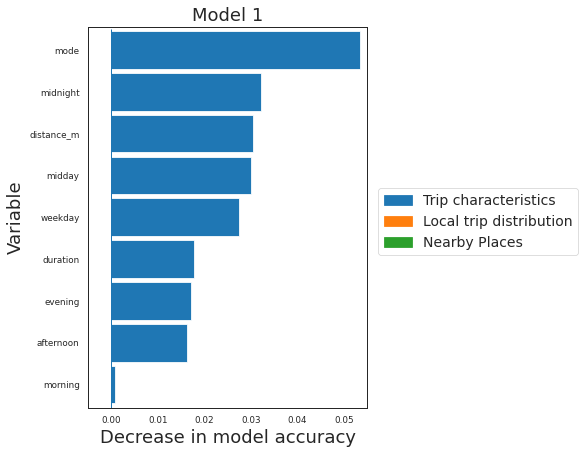

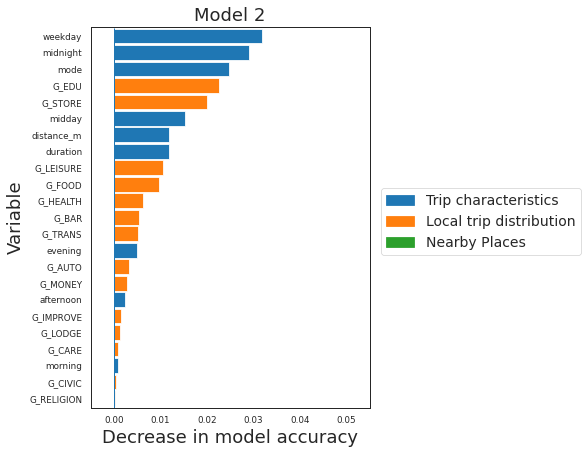

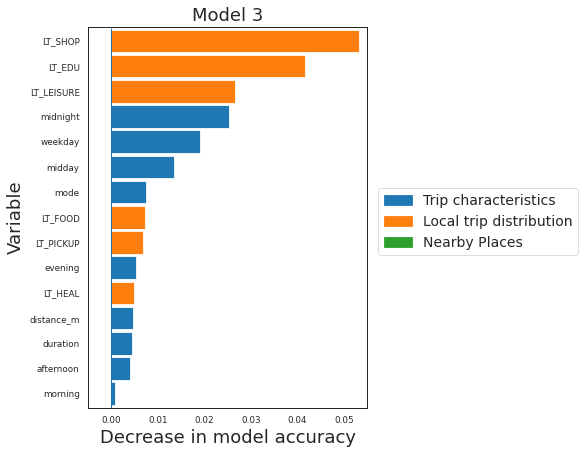

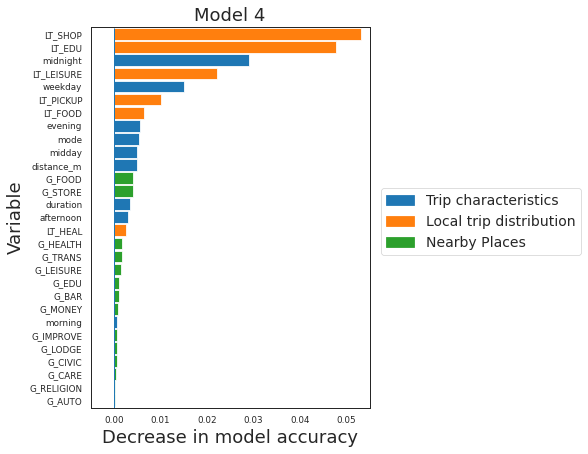

In [213]:
ALL_FEAT_IMP_MODELS = [model_1_feat_imp, model_2_feat_imp, model_3_feat_imp, model_4_feat_imp]
ALL_FEAT_IMP_NAMES =  ['model_1_feat_imp', 'model_2_feat_imp', 'model_3_feat_imp', 'model_4_feat_imp']
for i, model, model_name in zip(range(len(ALL_FEAT_IMP_MODELS)), ALL_FEAT_IMP_MODELS, ALL_FEAT_IMP_NAMES):
    ax = feat_imp_plots(model, model_number=i+1)
    make_legend(ax, loc=(1.04,0.4), fontsize=14)
#     plt.savefig('../../other/images/%s.tif' % (model_name),bbox_inches='tight',dpi = 300)

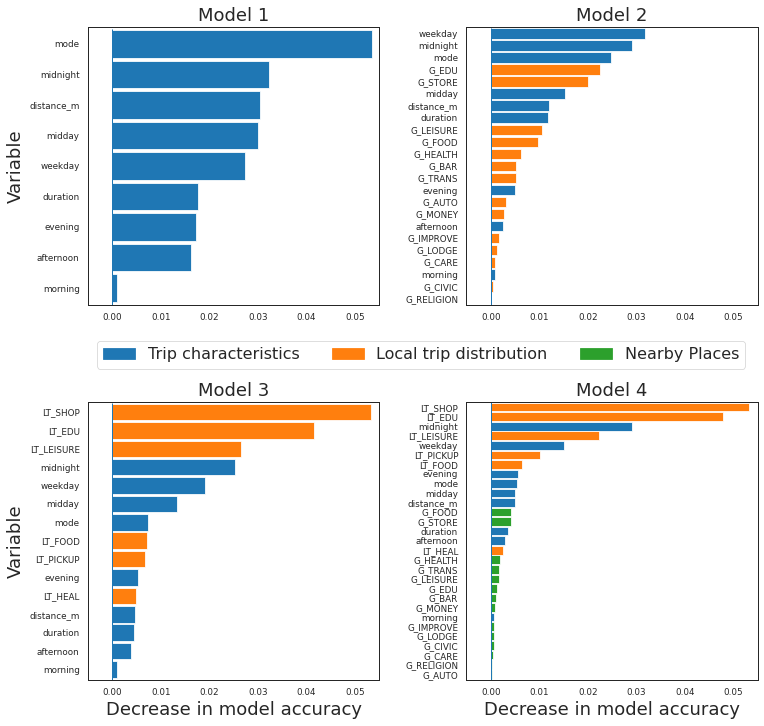

In [361]:
sns.set_style('white')
sns.set_context('paper')
## Subplot style
fig, axes = plt.subplots(2,2, figsize=(12,12))
plt.subplots_adjust(hspace=0.35)
plt.subplots_adjust(wspace=0.3)
ax_1 = 0
xlabel_d = False
ylabel_d = True
for i, model in enumerate(ALL_FEAT_IMP_MODELS):
    if i > 1:
        ax_1=1
        xlabel_d  = True
    feat_imp_plots(model, ax=axes[ax_1,i%2], model_number=i+1, xlabel=xlabel_d, ylabel=ylabel_d)
    ylabel_d = not ylabel_d
make_legend(axes[0,1], loc=(-1.27,-0.23), ncol=3, fontsize=16)
# plt.savefig('../../other/images/models_feat_imp.tif',bbox_inches='tight',dpi = 300)
# plt.savefig('../../other/images/models_feat_imp.png',bbox_inches='tight',dpi = 300)

### Model 4 by purpose

In [395]:
model_4_feat_imp = model_4_feat_imp.dropna()
ordered_features = model_4_feat_imp['Feature']
by_purpose_decrease_in_accpred = model_4_feat_imp[[ 'LEISURE','FOOD', 'SHOP', 'EDU', 'HEALTH']]
overall_decrease_in_accpred = model_4_feat_imp[['Unnamed: 8']]
## Decrease in accurate predictions due to permuting a feature

<ipython-input-419-532da000860d>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.figure.axes[-1].set_yticklabels(ax.figure.axes[-1].get_yticklabels(),fontsize=14);


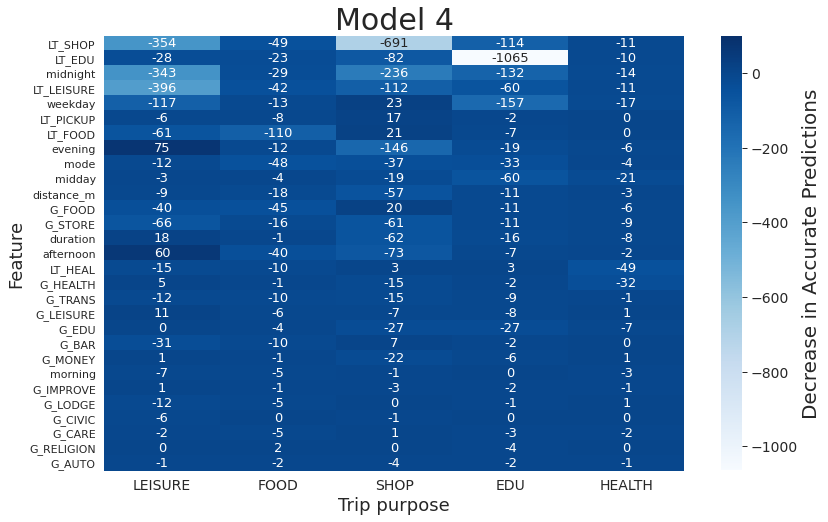

In [419]:
fig, ax = plt.subplots(1, figsize=(13,8))
sns.heatmap(by_purpose_decrease_in_accpred, ax=ax, cbar_kws={'label': 'Decrease in Accurate Predictions'},\
            annot=True, annot_kws={'size':13}, fmt='.0f', vmax=100, cmap=COLOUR_MAP)
ax.set_yticklabels(labels=ordered_features.values, rotation=0);

ax.set_xlabel("Trip purpose", size=18)
ax.figure.axes[-1].yaxis.label.set_size(20)
ax.figure.axes[-1].set_yticklabels(ax.figure.axes[-1].get_yticklabels(),fontsize=14);
plt.xticks(size=14)
plt.yticks(size=11)
ax.set_ylabel("Feature", size=18)
ax.set_title("Model 4", size=30)

# plt.savefig('../../other/images/model_4_feat_imp_by_purpose.tif',bbox_inches='tight',dpi = 300)
# plt.savefig('../../other/images/model_4_feat_imp_by_purpose.png',bbox_inches='tight',dpi = 300)

### Models by group

In [333]:
def feat_imp_grouped_plots(grp_feat_imp, model_number, ax=False, ylabel=True, xlabel=True):
    if not ax:
        fig, ax = plt.subplots(1, figsize=(4,6))
    ax.barh(grp_feat_imp[grp_feat_imp.Group == 'local trip distribution']['Group'],\
            grp_feat_imp[grp_feat_imp.Group == 'local trip distribution']['Importance'], height=0.65,color='C1')
    ax.barh(grp_feat_imp[grp_feat_imp.Group == 'trip characteristics']['Group'],\
            grp_feat_imp[grp_feat_imp.Group == 'trip characteristics']['Importance'], height=0.65,color='C0')
    ax.barh(grp_feat_imp[grp_feat_imp.Group == 'nearby places']['Group'],\
            grp_feat_imp[grp_feat_imp.Group == 'nearby places']['Importance'], height=0.65,color='C2')
    if xlabel:
        ax.set_xlabel("Decrease in model accuracy",size=14)
    if ylabel:
        ax.set_ylabel("Group",size=14)
    ax.set_title("Model %s" % (model_number), size=20)
    ax.set_xlim(0, 0.15)
    ax.set_yticklabels(labels=[], size=0)
    ax.invert_yaxis()
    return ax


In [334]:
ALL_GRP_FEAT_IMP_MODELS = [model_2_feat_imp_grp, model_3_feat_imp_grp, model_4_feat_imp_grp]

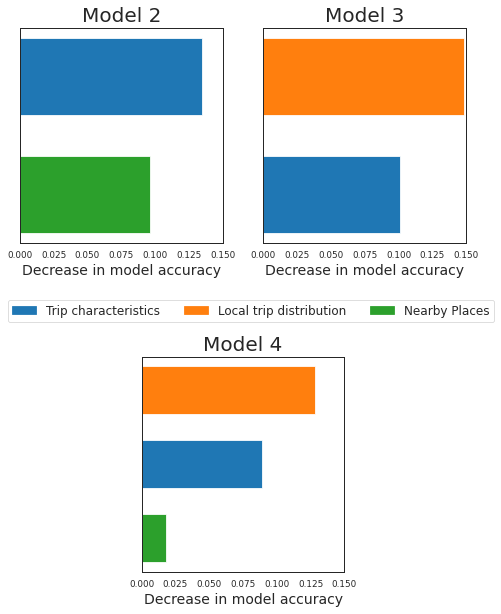

In [358]:
sns.set_style('white')
sns.set_context('paper')
## Subplot style
# Create 2x2 sub plots
gs = matplotlib.gridspec.GridSpec(2, 4)

fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(gs[0, :2]) # row 0, col 0
ax2 = fig.add_subplot(gs[0, 2:]) # row 0, col 0
ax3 = fig.add_subplot(gs[1, 1:3]) # row 0, col 0
ax_dict = {0:ax1, 1:ax2, 2:ax3}
plt.subplots_adjust(hspace=0.53)
plt.subplots_adjust(wspace=0.5)
for i, model in enumerate(ALL_GRP_FEAT_IMP_MODELS):

    feat_imp_grouped_plots(model, ax=ax_dict[i], model_number=i+2, xlabel=True, ylabel=False)
make_legend(ax2, loc=(-1.26,-0.37), ncol=3, fontsize=12)
# plt.savefig('../../other/images/models_feat_imp_grouped.tif',bbox_inches='tight',dpi = 300)
# plt.savefig('../../other/images/models_feat_imp_grouped.png',bbox_inches='tight',dpi = 300)

In [ ]:
# plt.savefig('../../other/images/feat_imp_by_group.tif',bbox_inches='tight',dpi = 300)

# 4. Spatial analysis of errors
We trying to discern if there are particular areas in the city where our model was less accurate for a given purpose class

4.1. General mapping  
4.2. Kernel density estimation (KDE)  
4.3. Spatial tests     

## 4.1. General mapping
Mapping of correcly and incorrectly  classified trips including by purpose

In [36]:
def plot_mtl_points(data, plot_title, ax=None, legend=True):
    """
        Plot points across the area of Montreal. Projection == Canada Lambert (epsg:3347)
        -----------------------------
        :params data: (geopandas.GeoDataFrame) Data containing Point objects as geometry
        :params plot_title: (string) Title for map
        :params ax: (matplotlib.axes._subplots.AxesSubplot) the axes of the figure for subplotting
        :params legend: (boolean) whether a legend should be plotted
        :return ax: (matplotlib.axes._subplots.AxesSubplot) the axes of the figure so it can be saved as an image or edited
    """
    if not ax:
        fig, ax  = plt.subplots(1)
    mtl_dissem.plot(ax=ax, color='lightgrey', linewidth=.1)
    data.plot(ax=ax, markersize=.8)
    ax.set_xlim(MIN_LON, MAX_LON)
    ax.set_ylim(MIN_LAT, MAX_LAT)
    if legend:
        ax.legend(['Trip end points'], fontsize=14, loc=(1.04,0.8))
    ax.set_title(plot_title, size=16)
    ax.set_xticklabels('');
    ax.set_yticklabels('');
    return ax

In [37]:
correct_trips = predictions_17_gdf.loc[predictions_17_gdf['correct'] == True]
incorrect_trips = predictions_17_gdf.loc[predictions_17_gdf['correct'] == False]
in_the_city = gpd.sjoin(city_of_montreal, predictions_17_gdf, how='left', op='intersects')
outside_the_city = predictions_17_gdf.loc[~predictions_17_gdf['id_trip'].isin(in_the_city['id_trip'].unique())]

/home/thomaskeel/anaconda3/envs/datasci/lib/python3.8/site-packages/geopandas/tools/sjoin.py:58: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:3347'} != EPSG:3347)
  warn(


In [38]:
## look at how many correct/incorrect trips there are within and outside the City of Montreal
print('Trips in the city')
print(in_the_city['correct'].value_counts(), '\n')
print('Trips outside the city')
print(outside_the_city['correct'].value_counts())

Trips in the city
True     2666
False    2192
Name: correct, dtype: int64 

Trips outside the city
True     485
False    394
Name: correct, dtype: int64


<AxesSubplot:title={'center':'Incorrectly classified trips (n=2586)'}>

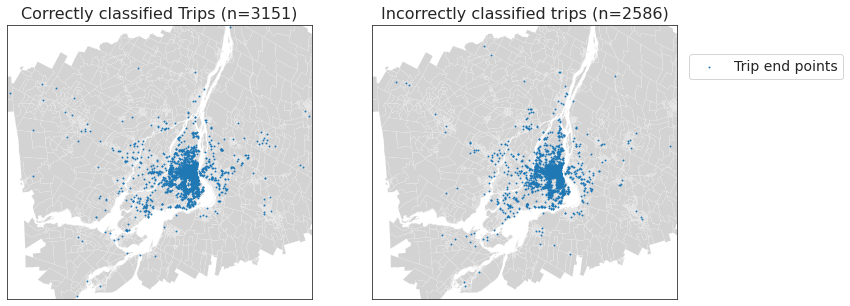

In [39]:
fig, axes = plt.subplots(1,2, figsize=(12,8))
plot_mtl_points(correct_trips, plot_title='Correctly classified Trips (n=%s)' % (len(correct_trips)),\
                ax=axes[0], legend=False)
plot_mtl_points(incorrect_trips, plot_title='Incorrectly classified trips (n=%s)'% (len(incorrect_trips)),\
                ax=axes[1])

##### Interpretation
    o Extreme spatial un-eveness of trip end points
    o Correctly and Incorrectly classified trips are relatively indistinguishable in this visualisation. We need to investigate individual purpose types


Compare true vs false for each purpose type

In [40]:
def plot_mtl_points_truevsfalse(data, plot_title, ax=None, legend=False):
    """
        Plot points across the area of Montreal True vs False. Projection == Canada Lambert (epsg:3347)
        --------------------------
        :params data: (geopandas.GeoDataFrame) Data containing Point objects as geometry
        :params plot_title: (string) Title for map
        :params ax: (matplotlib.axes._subplots.AxesSubplot) the axes of the figure for subplotting
        :params legend: (boolean) whether a legend should be plotted
        :return ax: (matplotlib.pyplot.figure.axes) the axes of the figure so it can be saved as an image or edited
    """
    if not ax:
        fig, ax = plt.subplots(1)
    mtl_dissem.plot(ax=ax, color='lightgrey', linewidth=.1)
    data.plot('correct', cmap='bwr',categorical=True, legend=legend, s=3, ax=ax, legend_kwds={'loc':(1.04,0.5),\
                                                                                         'fontsize':14})
    ax.set_xlim(MIN_LON, MAX_LON)
    ax.set_ylim(MIN_LAT, MAX_LAT)
    ax.set_title(plot_title, size=14)
    ax.set_xticklabels('');
    ax.set_yticklabels('');
    return ax

In [41]:
def true_false_title(pur, data):
    """
       Returns a title with true and false values for that purpose
       -------------------
       :params pur: (int) purpose number
       :params data: (DataFrame) data containing predictions of each purpose
       :return title: (str) a title to be used in a plot
    """
    title = 'Prediction: ' + LONG_NAMES[pur] + ' (T=%s F=%s)' % (data['correct'].value_counts()[True], data['correct'].value_counts()[False]) # SAFER ALTERNATIVE  purpose_name = PURPOSE_CLASSES[pur].capitalize() + ' trips'
    return title 


def basic_title_func(pur, data):
    return LONG_NAMES[pur]


def subplot_of_each_purpose(data, num_columns, num_rows, plot_func, title_func, suptitle='', legend=False):
    """
        Plots a map for each purpose. Takes a plot function (plot_func) and title function (title_func)
        and uses these to build the subplot of each purpose type
        -----------------
        :params data: (DataFrame) predictions data
        :params num_columns: (int) Number of subplots to a columns
        :params num_rows: (int) Number of subplots to a row
        :params plot_func: (function) Function for creating a subplot visualisation
        :params title_func: (function) Function for creating a plot title for each subplots 
        :params suptitle: (str) Super-title for the plot
        :params legend: (boolean) whether the plot function contains legend argument 
        :return fig: (matplotlib.pyplot.figure) For saving the figure
    """
    
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(20,12))
    row_ind = -1 # start at -1 so it can be incremented once before first plot
    for pur in sorted(data['prediction'].unique()):
        pur_data = data.loc[data.prediction == pur]
        plot_title = title_func(pur, pur_data)
        if pur % num_columns == 0:
            # increment the row index if the row is full
            row_ind += 1
        col_ind = pur % num_columns
        if legend and col_ind == num_columns - 1:
            plot_func(pur_data, plot_title=plot_title, ax=axes[row_ind][col_ind], legend=True)
        else:
            plot_func(pur_data, plot_title=plot_title, ax=axes[row_ind][col_ind])
    plt.suptitle(suptitle, size=26)
    return fig

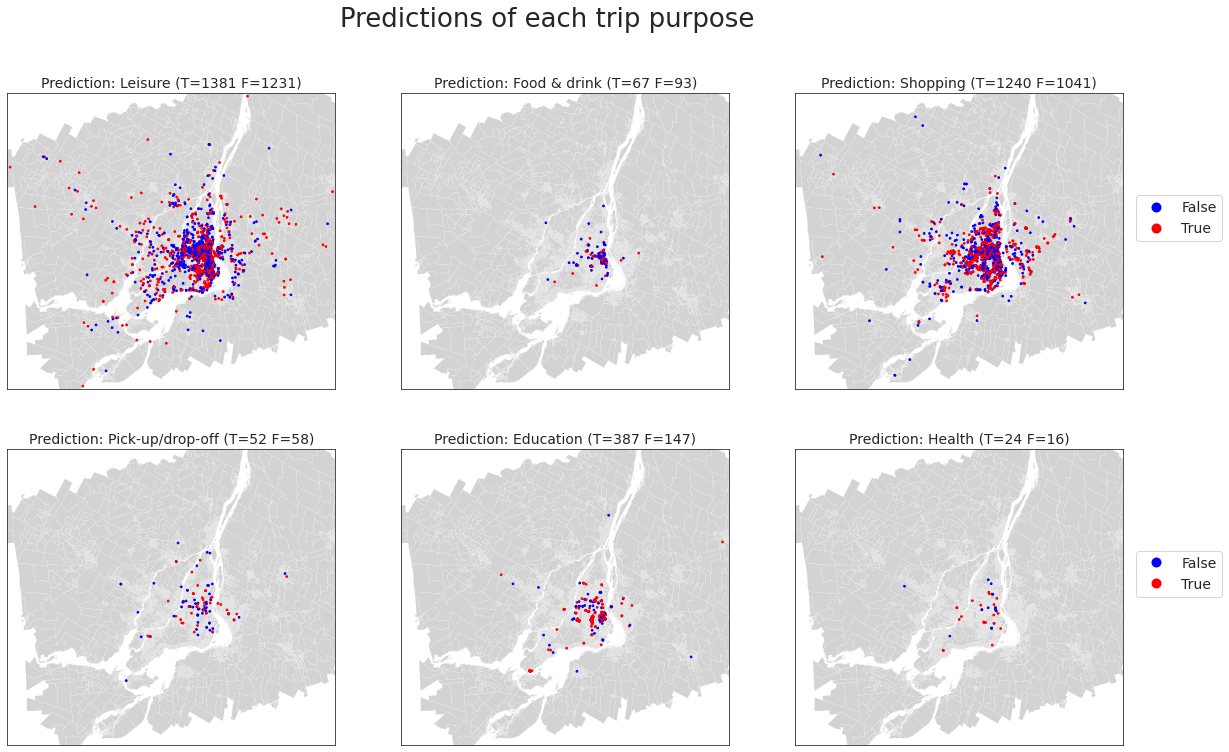

In [42]:
fig = subplot_of_each_purpose(data=predictions_17_gdf, num_columns=3, num_rows=2,\
                        plot_func=plot_mtl_points_truevsfalse, title_func=true_false_title,\
                        suptitle='Predictions of each trip purpose', legend=True)

##### Interpretation
It is difficult to interpret these maps visually as there are still 100 to 1000s of trips on some of these maps. 

###### Basic Intrepretation
    o Roughly, and as expected (from the underlying distribution of trip end points), more correctly classified trips are found in the area of Downtown Montreal across all purpose types
    o Where predictions of trips of the same purpose are not near other trips that are predicted to be that purpose (i.e. typically at the further extent of the study area) they are relatively inaccurate (except for leisure & shopping)

Actual values in and outside the city

In [43]:
## look at how many correct/incorrect trips there are within and outside the City of Montreal
print('-'*50)
for pur in sorted(predictions_17_gdf['prediction'].unique()):
    print(LONG_NAMES[pur] + ':')
    print('Trips in the city:')
    print(in_the_city.loc[in_the_city.prediction == pur]['correct'].value_counts().sort_index(ascending=False), '\n')
    print('Trips outside the city:')
    print(outside_the_city.loc[outside_the_city.prediction == pur]['correct'].value_counts().sort_index(ascending=False))
    print('-'*50)

--------------------------------------------------
Leisure:
Trips in the city:
True     1140
False    1013
Name: correct, dtype: int64 

Trips outside the city:
True     241
False    218
Name: correct, dtype: int64
--------------------------------------------------
Food & drink:
Trips in the city:
True     64
False    90
Name: correct, dtype: int64 

Trips outside the city:
True     3
False    3
Name: correct, dtype: int64
--------------------------------------------------
Shopping:
Trips in the city:
True     1045
False     896
Name: correct, dtype: int64 

Trips outside the city:
True     195
False    145
Name: correct, dtype: int64
--------------------------------------------------
Pick-up/drop-off:
Trips in the city:
True     40
False    46
Name: correct, dtype: int64 

Trips outside the city:
True     12
False    12
Name: correct, dtype: int64
--------------------------------------------------
Education:
Trips in the city:
True     358
False    134
Name: correct, dtype: int64 

Tr

##### Interpretation
see percentage interpretation

Percentage

In [44]:
## look at the proportion of correct/incorrect trips there are within and outside the City of Montreal
print('-'*50)
for pur in sorted(predictions_17_gdf['prediction'].unique()):
    print(LONG_NAMES[pur] + ':')
    print('Trips in the city:')
    print((in_the_city.loc[in_the_city.prediction == pur]['correct'].value_counts().sort_index(ascending=False) / len(in_the_city.loc[in_the_city.prediction == pur]))*100, '\n')
    print('Trips outside the city:')
    print((outside_the_city.loc[outside_the_city.prediction == pur]['correct'].value_counts().sort_index(ascending=False) / len(outside_the_city.loc[outside_the_city.prediction == pur]))*100)
    print('-'*50)

--------------------------------------------------
Leisure:
Trips in the city:
True     52.949373
False    47.050627
Name: correct, dtype: float64 

Trips outside the city:
True     52.505447
False    47.494553
Name: correct, dtype: float64
--------------------------------------------------
Food & drink:
Trips in the city:
True     41.558442
False    58.441558
Name: correct, dtype: float64 

Trips outside the city:
True     50.0
False    50.0
Name: correct, dtype: float64
--------------------------------------------------
Shopping:
Trips in the city:
True     53.838228
False    46.161772
Name: correct, dtype: float64 

Trips outside the city:
True     57.352941
False    42.647059
Name: correct, dtype: float64
--------------------------------------------------
Pick-up/drop-off:
Trips in the city:
True     46.511628
False    53.488372
Name: correct, dtype: float64 

Trips outside the city:
True     50.0
False    50.0
Name: correct, dtype: float64
-----------------------------------------

##### Interpretation
    o Food and Drink trips are incorrectly classified inside the City more times (42%) than they are correctly classified (58%)
    o Education has the highest percentage of correctly classified trips in the City (73%)
    o Highest percentage of trips correctly classified outside the City are Education (69%), Health (63%) and Shopping (57%)

## 4.2 Heatmaps and Kernel Density Estimation (KDE) plots
TODO: determine the kernel & band-width

In [74]:
??sns.kdeplot

In [83]:
def plot_mtl_kde(data, plot_title, ax=None):
    """
        Plot KDE across the area of Montreal. Projection == Canada Lambert (epsg:3347)
        --------------------------
        :params data: (geopandas.GeoDataFrame) Data containing Point objects as geometry
        :params plot_title: (string) Title for map
        :params ax: (matplotlib.axes._subplots.AxesSubplot) the axes of the figure for subplotting
        :return ax: (matplotlib.pyplot.figure.axes) the axes of the figure so it can be saved as an image or edited
    """
    if not ax:
        fig, ax = plt.subplots(1)
    mtl_dissem.plot(ax=ax, color='lightgrey', linewidth=.1)
    sns.kdeplot(x=data.endx, y=data.endy, bw_method=.4, cmap='viridis', ax=ax)
    ax.set_xlim(MIN_LON, MAX_LON)
    ax.set_ylim(MIN_LAT, MAX_LAT)
    ax.set_xticklabels([]);
    ax.set_yticklabels([]);
    ax.set_xlabel("");
    ax.set_ylabel("");
    ax.set_title(plot_title, size=20)
    return ax

<AxesSubplot:title={'center':'All trips'}>

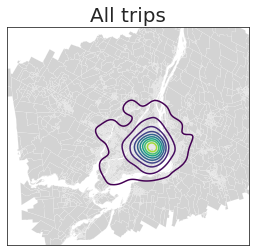

In [84]:
plot_mtl_kde(predictions_17, 'All trips')

KDE of correctly and incorrectly predicted trips

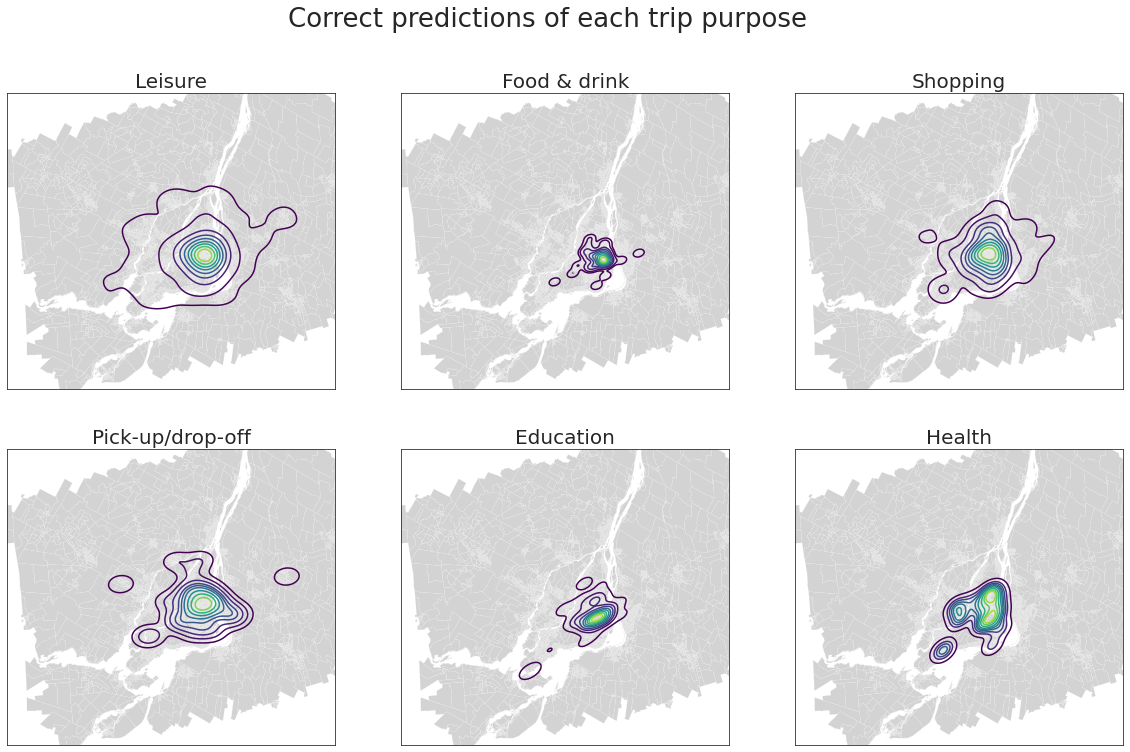

In [85]:
fig = subplot_of_each_purpose(data=correct_trips, num_columns=3, num_rows=2,\
                        plot_func=plot_mtl_kde, title_func=basic_title_func,\
                        suptitle='Correct predictions of each trip purpose', legend=False)

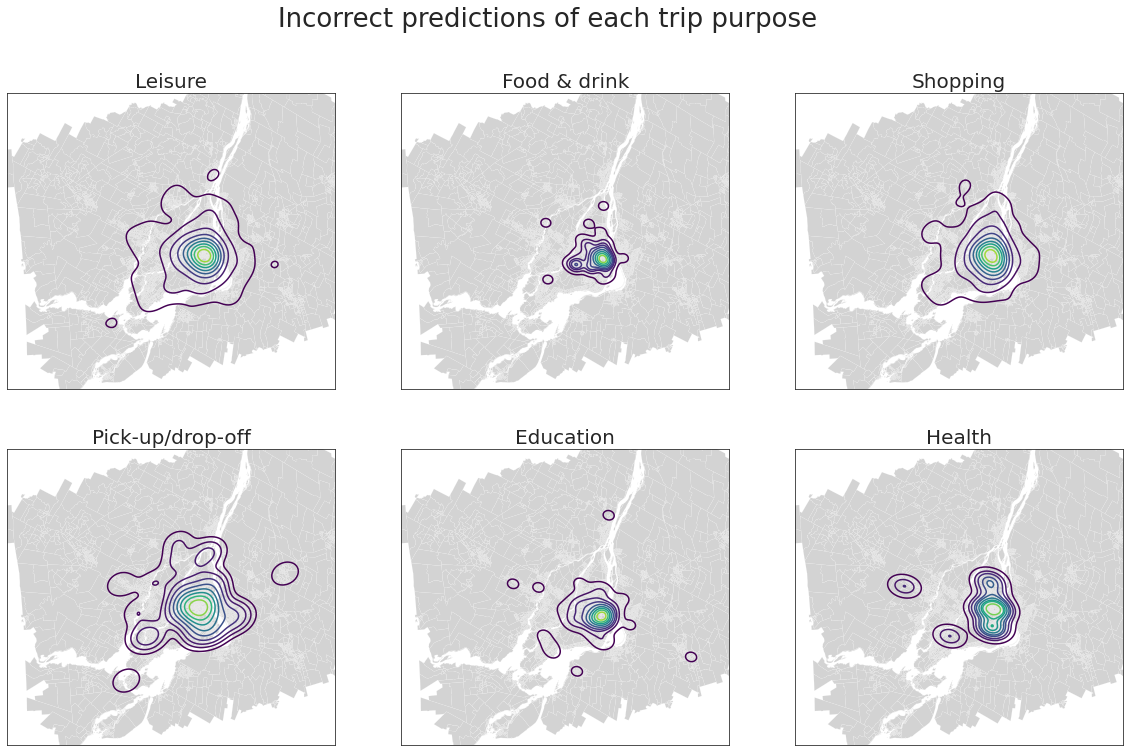

In [86]:
fig = subplot_of_each_purpose(data=incorrect_trips, num_columns=3, num_rows=2,\
                        plot_func=plot_mtl_kde, title_func=basic_title_func,\
                        suptitle='Incorrect predictions of each trip purpose', legend=False)

KDE of incorrectly predicted trips

##### Intrepretation
    o Education is highly concentrated around Downtown Montreal
    o Health & Pu/Do highest kernel range 

Within and outside the city KDE (overall)

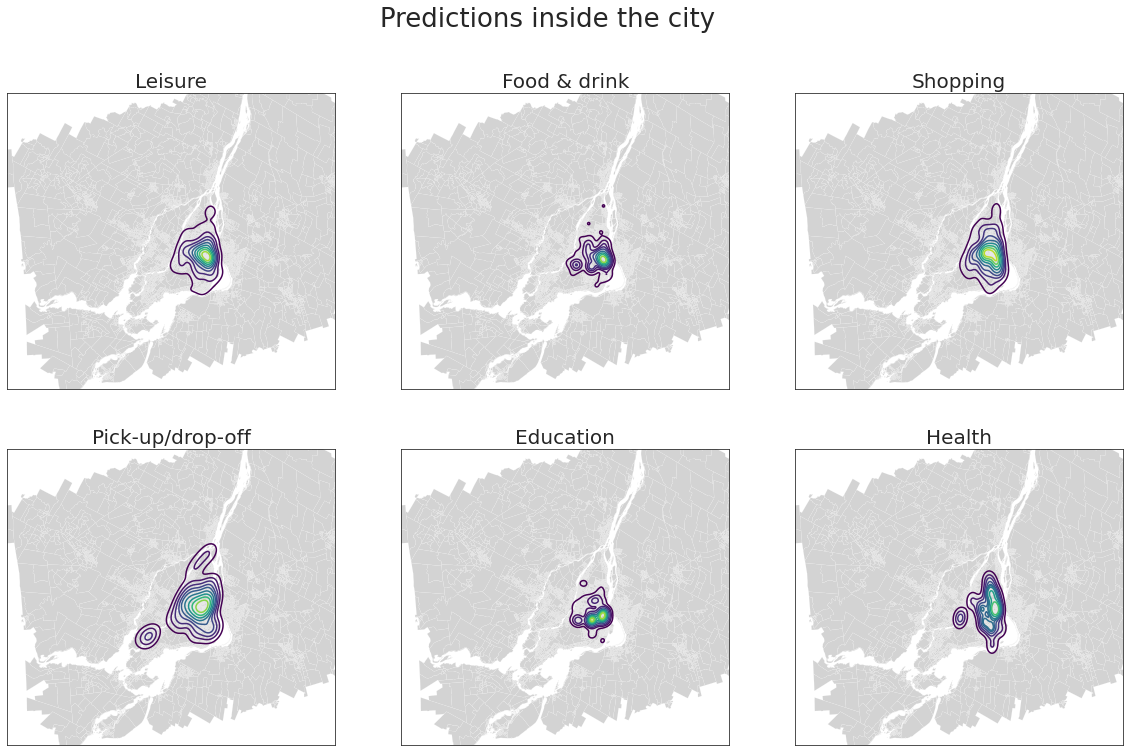

In [87]:
fig = subplot_of_each_purpose(data=in_the_city, num_columns=3, num_rows=2,\
                        plot_func=plot_mtl_kde, title_func=basic_title_func,\
                        suptitle='Predictions inside the city', legend=False)

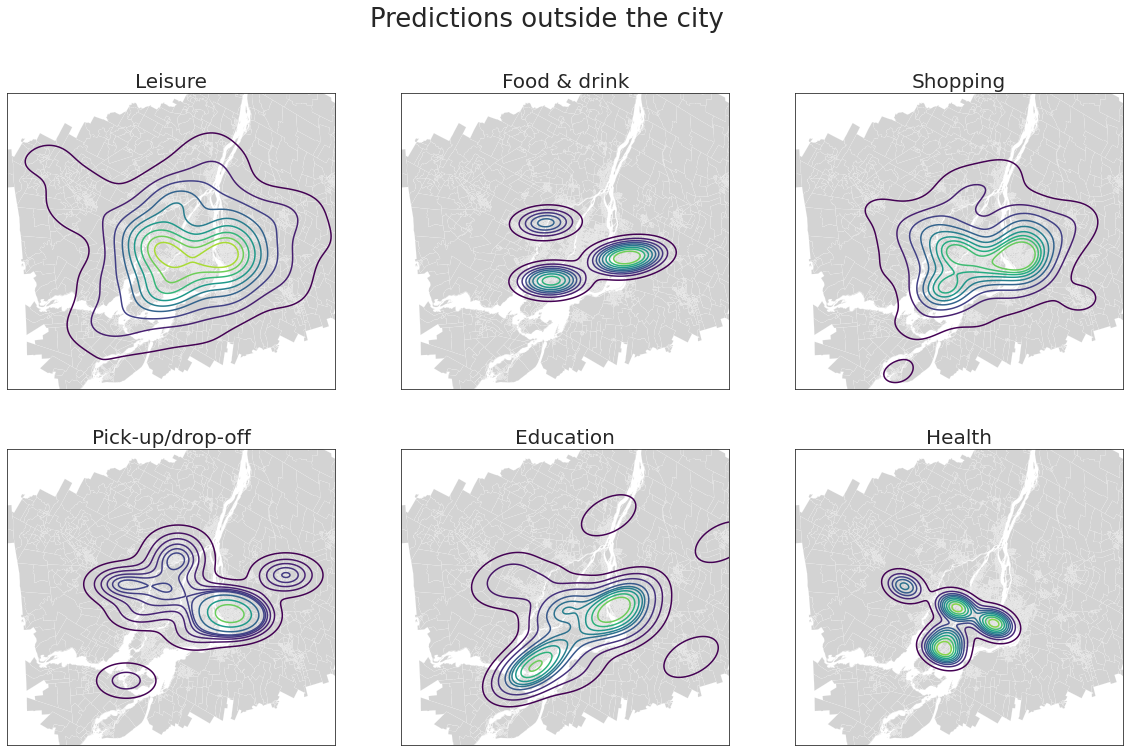

In [88]:
fig = subplot_of_each_purpose(data=outside_the_city, num_columns=3, num_rows=2,\
                        plot_func=plot_mtl_kde, title_func=basic_title_func,\
                        suptitle='Predictions outside the city', legend=False)

##### Intrepretation
    o Majority trips are towards the south of Montreal Island and across the river from downtown
    o Pick-up/drop-off has one main cluster

## 4.3 Spatial Statistics
    4.3.1 Spatial auto-correlation   
    4.3.2 Spatial dependency   

### 4.3.1 Spatial dependency & auto-correlation
Description:

In [51]:
def aggregate_data_into_dissemination_areas(data, dissemination_areas, grouped_column):
    """
        Aggregates prediction data (Point data) into the Montreal Dissemination areas.
        First it spatially joins the two based on trips (Points) which are found within a given areas (Polygons).
        Both data projections must be the same (i.e. EPSG:3347)
        ------------------------
        :params data: (Geopandas.GeoDataFrame) Main prediction data
        :params dissemination_areas: (Geopandas.GeoDataFrame) Data containing Polygon geometry columns
        :params grouped_column: (string) Column to include in aggregation 
        :return aggregated_data: (Geopandas.GeoDataFrame) Data containing the aggregated predictions into each dissemination area
    """
    aggregated_data = gpd.sjoin(data, dissemination_areas, op='within')
    
    # check for duplicates
    assert len(aggregated_data) == aggregated_data['id_trip'].nunique()
    
    # groupby data by count of each purpose type in each unique Dissemination area ID (DAUID) and whether the prediction was correct or not
    aggregated_data = aggregated_data.groupby(['correct',grouped_column,'DAUID']).size()
    # rotate data so index becomes columns (so columns are: (True/False and purpose class))
    aggregated_data = aggregated_data.unstack().T.reset_index()
    
    # merge data back to original data so we can extract the geometry (Polygons)
    aggregated_data = aggregated_data.merge(dissemination_areas[['DAUID','geometry']], on='DAUID', how='outer')
    
    # replace NaN values (where no trip is recorded in )
    aggregated_data = aggregated_data.replace(np.nan, 0)
    
    # drop and rename columns 
    aggregated_data = aggregated_data.drop(aggregated_data.columns[1],axis=1) # drops duplicate DAUID column
    aggregated_data.columns = [replace_parenthesis(col_name) for col_name in aggregated_data.columns]
    
    # turn back into GeoDataFrame object for plotting
    aggregated_data = gpd.GeoDataFrame(aggregated_data)
    
    return aggregated_data


def replace_parenthesis(some_text):
    """
        Simple function for removing unwanted parentheses and commas from a string
        ------------------------
        :params some_text: (string) some text
        :return formatted_text: (string) formatted text with no parentheses and commas
    """
    
    some_text = str(some_text)
    formatted_text = some_text.replace('(','').replace(')','').replace(',','').replace(' ','')
    return formatted_text

In [52]:
aggregated_data = gpd.sjoin(predictions_17_gdf, mtl_dissem, op='within')
# check for duplicates
assert len(aggregated_data) == aggregated_data['id_trip'].nunique()

# groupby data by count of each purpose type in each unique Dissemination area ID (DAUID) and whether the prediction was correct or not
aggregated_data = aggregated_data.groupby(['correct','prediction','DAUID']).size()
# rotate data so index becomes columns (so columns are: (True/False and purpose class))
aggregated_data = aggregated_data.unstack().T.reset_index()

# merge data back to original data so we can extract the geometry (Polygons)
aggregated_data = aggregated_data.merge(mtl_dissem[['DAUID','geometry']], on='DAUID', how='outer')

# replace NaN values (where no trip is recorded in )
aggregated_data = aggregated_data.replace(np.nan, 0)
aggregated_data = aggregated_data.drop(aggregated_data.columns[1],axis=1) # drops duplicate DAUID column
aggregated_data.columns = [replace_parenthesis(col_name) for col_name in aggregated_data.columns]

aggregated_data = gpd.GeoDataFrame(aggregated_data)

/home/thomaskeel/anaconda3/envs/datasci/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


In [53]:
prediction_aggregated_data = aggregate_data_into_dissemination_areas(predictions_17_gdf, mtl_dissem, 'prediction')
purpose_aggregated_data = aggregate_data_into_dissemination_areas(predictions_17_gdf, mtl_dissem, 'purpose')

/home/thomaskeel/anaconda3/envs/datasci/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)
/home/thomaskeel/anaconda3/envs/datasci/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


In [54]:
len(prediction_aggregated_data)

7046

In [55]:
prediction_aggregated_data.head()

DAUID  False0  False1  False2  False3  False4  False5  True0  True1  \
0  24540133     1.0     0.0     0.0     0.0     0.0     0.0    0.0    0.0   
1  24540178     0.0     0.0     0.0     0.0     0.0     0.0    0.0    0.0   
2  24540250     0.0     0.0     0.0     0.0     0.0     0.0    1.0    0.0   
3  24550057     0.0     0.0     0.0     0.0     0.0     0.0    1.0    0.0   
4  24550058     0.0     0.0     0.0     0.0     0.0     0.0    1.0    0.0   

   True2  True3  True4  True5  \
0    0.0    0.0    0.0    0.0   
1    0.0    0.0    1.0    0.0   
2    0.0    0.0    0.0    0.0   
3    0.0    0.0    0.0    0.0   
4    0.0    0.0    0.0    0.0   

                                            geometry  
0  MULTIPOLYGON (((7674213.277 1264435.594, 76742...  
1  MULTIPOLYGON (((7672887.480 1271980.594, 76729...  
2  MULTIPOLYGON (((7673974.414 1269300.571, 76746...  
3  MULTIPOLYGON (((7672195.400 1249302.023, 76721...  
4  MULTIPOLYGON (((7674186.126 1254908.231, 76741...

In [56]:
# build Queen's case spatial weight matrix
wq = ps.lib.weights.contiguity.Queen.from_dataframe(mtl_dissem)

/home/thomaskeel/anaconda3/envs/datasci/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 14 disconnected components.
 There are 4 islands with ids: 3641, 4879, 6388, 6599.
  warnings.warn(message)


<AxesSubplot:>

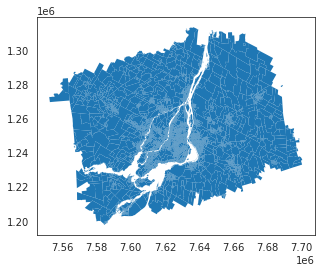

In [57]:
# dissemination areas 
mtl_dissem.plot(linewidth=0.0001)

('WARNING: ', 3641, ' is an island (no neighbors)')
('WARNING: ', 4879, ' is an island (no neighbors)')
('WARNING: ', 6388, ' is an island (no neighbors)')
('WARNING: ', 6599, ' is an island (no neighbors)')
Moran's I: -0.0022140376006491804 P-value (simulated): 0.385


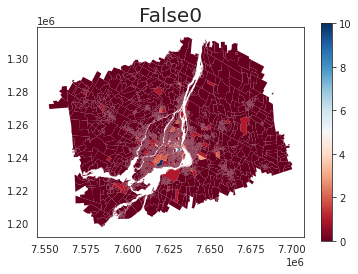

Moran's I: 0.001120323573085746 P-value (simulated): 0.286


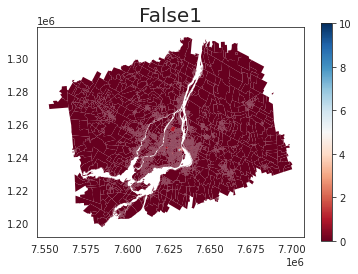

Moran's I: -0.003332212924756689 P-value (simulated): 0.294


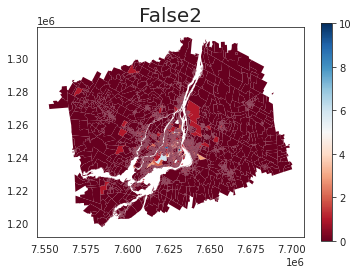

Moran's I: -0.0074687681391255294 P-value (simulated): 0.017


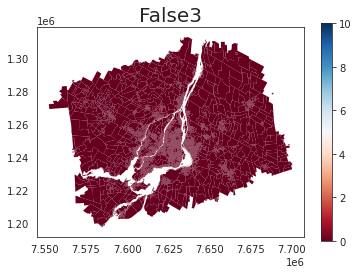

Moran's I: 0.0017898601811526464 P-value (simulated): 0.231


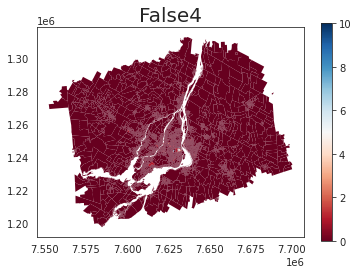

Moran's I: -0.001560812369001651 P-value (simulated): 0.176


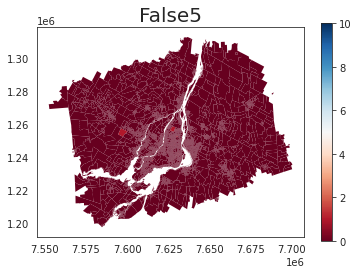

Moran's I: 0.0008154546542346791 P-value (simulated): 0.399


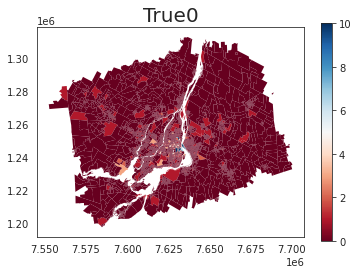

Moran's I: -0.0017745306802142572 P-value (simulated): 0.376


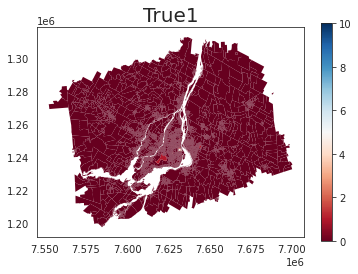

Moran's I: -0.003355289701407547 P-value (simulated): 0.333


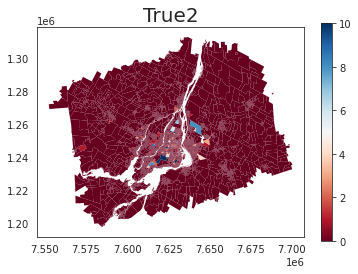

Moran's I: 0.010433679176309007 P-value (simulated): 0.098


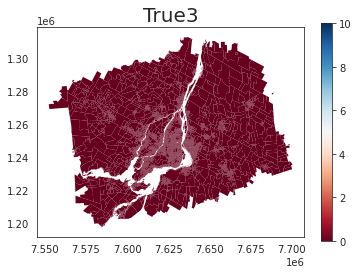

Moran's I: -0.0009215960657430854 P-value (simulated): 0.384


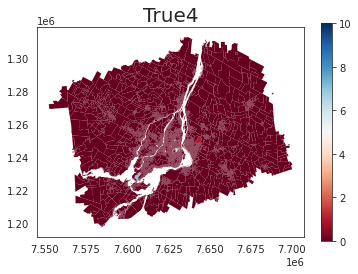

Moran's I: -0.0030558788879863578 P-value (simulated): 0.474


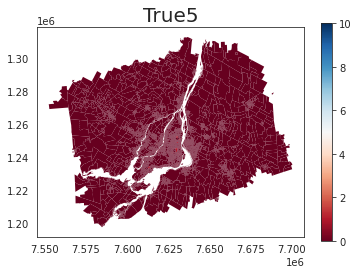

CPU times: user 17.2 s, sys: 1.41 s, total: 18.6 s
Wall time: 16.8 s


In [58]:
%%time
VMAX = 10

for col in prediction_aggregated_data.columns[1:-1]:
    # calculate local Moran's I
    y = prediction_aggregated_data[col].values
    moran_global = esda.Moran(y, wq)
    print("Moran's I:", moran_global.I, "P-value (simulated):", moran_global.p_sim)
    
    prediction_aggregated_data.plot(col,cmap='RdBu', legend=True, linewidth=0, vmax=VMAX)
    plt.title(col, size=20)
    plt.show()

In [90]:
import pysal.explore

In [93]:
len(y) == wq.n

True

In [94]:
def lisa_plot(data, column, weight_matrix, dissemination_areas):
    """
       Calculate Local Moran's I (a test for spatial auto-correlation within each dissemenation area)
       then map the values of I in a Local Indicator of Spatial Association (LISA) plot.
       HH == High-High (High values of Moran's I surrounded by High values)
       HL == High-Low (High values of Moran's I surrounded by Low values)
       LH == Low-High (...)
       LL == Low-Low (...)
       ns == not significant
    """
    # build spatial weight matrix and calculate Global and Local Moran's I
    y = data[column].values
    moran_loc = esda.Moran_Local(y, weight_matrix)
    fig, ax = plt.subplots(1)
    splot.esda.lisa_cluster(moran_loc, dissemination_areas, ax=ax, legend_kwds={'title':'LISA', 'fontsize':12})
    ax.set_title("LISA map "+col, size=22)
#     print(moran_loc.Is)
#     print(moran_loc.p_sim)
    return ax

In [95]:
%%time
for col in prediction_aggregated_data.columns[1:-1]:
    lisa_plot(prediction_aggregated_data, col, wq, mtl_dissem)
    plt.show()

ValueError: cannot assign slice from input of different size

# 5. Temporal analysis
We trying to discern if there are particular times of day, days of week or weeks of month where our model was less accurate for a given purpose class
    
    5.0. Underlying temporal distribution of trips
    5.1. Time-series of errors  
    5.2. Calendar plot of errors   
    5.3. Temporal decomposition  
    5.4. Augmented Dickey-Fuller (ADF) test  


## 5.0 Underlying temporal distribution of trips
look at the underlying distribution of trips within the prediction data

In [96]:
count_of_prediction_each_day = predictions_17.set_index('endtime').groupby([pd.Grouper(freq='1d')]).size()

Text(0, 0.5, 'Count')

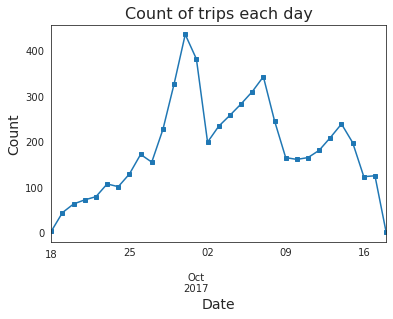

In [97]:
count_of_prediction_each_day.plot(marker='s', markersize=4)
plt.title('Count of trips each day', size=16)
plt.xlabel('Date', size=14)
plt.ylabel('Count', size=14)

##### Interpretation
    o The most amount of trips are found between 29th – 30th September, 5th – 7th October
    

## 5.1 Time-series of errors

    5.1.1 by day
    5.1.2 by hour

In [98]:
def group_time_data_by_purpose(time_data, frequency, purposes):
    """
        Subset data into purpose then group the data into a given frequency of time
        ---------------
        :params time_data: (pandas.DataFrame) Data with a datetime index
        :params frequency: (string) the frequency of time that the data will be grouped by
        :params purposes: (string or list) Purpose classes to subset the data by
        :return grouped_data: (pandas.DataFrame) data 
    """
    if not type(purposes) == list:
        purposes = [purposes]
    # subset data
    time_data = time_data.loc[time_data.purpose.isin(purposes)]
    # group data by time frequency
    grouped_data = time_data.groupby(pd.Grouper(freq=frequency)).agg({'correct':'mean'})
    return grouped_data

### 5.1.1. by day

- TODO: drop accuracy values if a trip doesn't exist

In [99]:
# Create a dataframe containing the correct prediction made per unique timestamp
correct_predictions_per_timestamp = predictions_17.set_index(['endtime'])[['correct','purpose','prediction']]

In [100]:
correct_predictions_per_timestamp.head()

correct  purpose  prediction
endtime                                          
2017-09-18 10:17:12    False        3           2
2017-09-18 20:52:00     True        2           2
2017-09-18 21:29:53    False        3           2
2017-09-19 00:57:31    False        2           0
2017-09-19 12:05:06    False        5           2

In [101]:
# use the function defined above to calculate the proportion of correct trips of each class per day
frequency = '1d' # One day
correct_predictions_by_day = group_time_data_by_purpose(correct_predictions_per_timestamp,
                                                        frequency=frequency, purposes=[0,1,2,3,4,5])

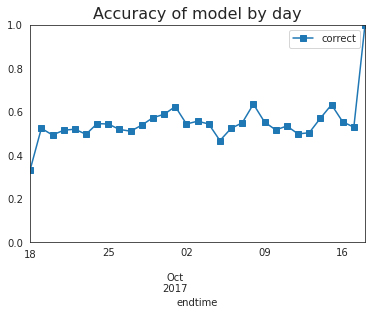

In [102]:
correct_predictions_by_day.plot(marker='s')
plt.title('Accuracy of model by day', size=16)
plt.ylim(0,1)
plt.show()

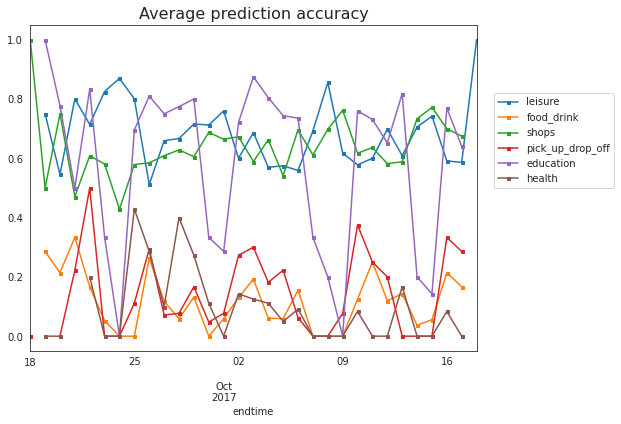

In [103]:
fig, ax  = plt.subplots(1, figsize=(8,6))
for pur in sorted(correct_predictions_per_timestamp['purpose'].unique()):
    pur_df = group_time_data_by_purpose(correct_predictions_per_timestamp, '1d', [pur])
    pur_df.plot(marker='s', markersize=3, ax=ax)
plt.title('Average prediction accuracy', size=16)
plt.legend(PURPOSE_CLASSES.values(), loc=(1.04,0.5))

### 5.1.2 by hour

In [104]:
def average_accuracy_by_hour(data, plot_title, frequency = '1h', purposes=[0,1,2,3,4,5]):
    fig, ax = plt.subplots(1, figsize=(10,6))
    
    # Create a dataframe containing the correct prediction made per unique timestamp
    correct_predictions_per_timestamp = data.set_index(['endtime'])[['correct','purpose','prediction']]
    
    # use the function defined above to calculate the proportion of correct trips of each class per day
    correct_predictions_by_hour = group_time_data_by_purpose(correct_predictions_per_timestamp,
                                                        frequency=frequency, purposes=purposes)
    
    # create an hour column to perform groupby on
    correct_predictions_by_hour['hour'] = correct_predictions_by_hour.index.hour
    
    # perform groupby
    grouped_predictions_by_hour = correct_predictions_by_hour.groupby(['hour']).agg({'correct':'mean'}) * 100
    
    # plot data
    grouped_predictions_by_hour.plot.bar(ax=ax, legend=False)
    grouped_predictions_by_hour.plot(ax=ax, legend=False, marker='s', color='k', alpha=.75)
    ax.set_ylabel('Average Accuracy (%)', size=20)
    ax.set_xlabel('Hour of day', size=20)
    ax.set_ylim(0,100)
    ax.set_xlim(-0.5,23.5)    
    ax.set_title(plot_title, size=24)
    plt.yticks(size=16)
    plt.xticks(size=16, rotation=0)
    return ax

In [105]:
predictions_17_gdf['endtime'].apply(lambda row: row.hour).value_counts()

21    569
22    558
16    480
23    474
20    453
17    445
19    387
15    365
18    348
13    291
14    280
0     267
12    267
1     181
11    112
2     110
3      51
4      37
5      24
10     22
6       8
7       4
9       2
8       2
Name: endtime, dtype: int64

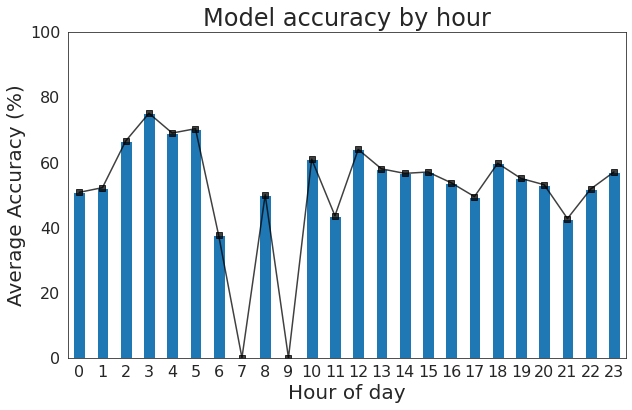

In [106]:
ax = average_accuracy_by_hour(predictions_17_gdf, plot_title='Model accuracy by hour')


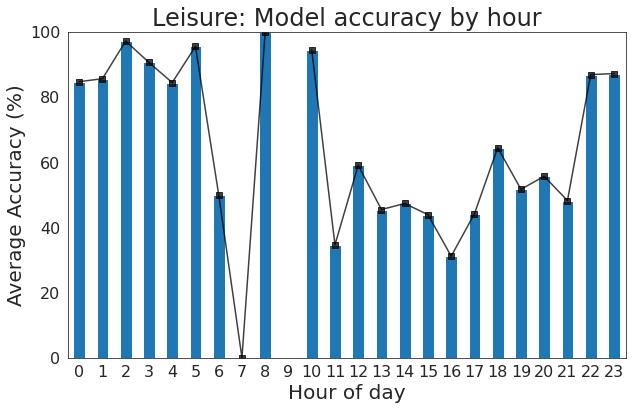

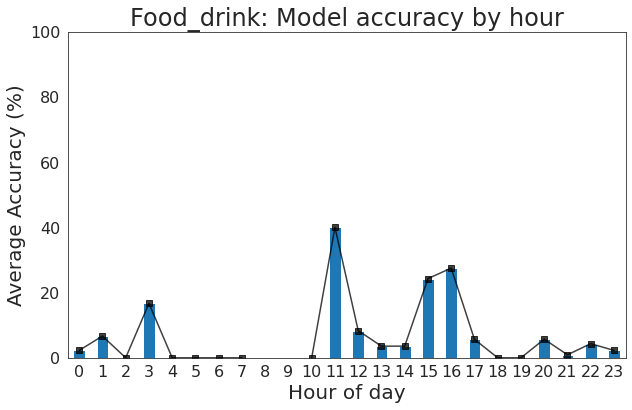

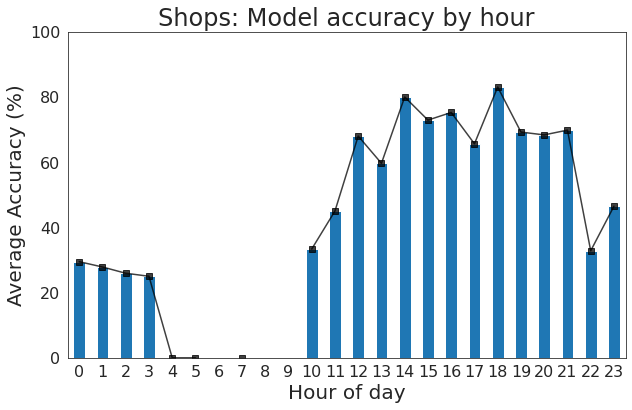

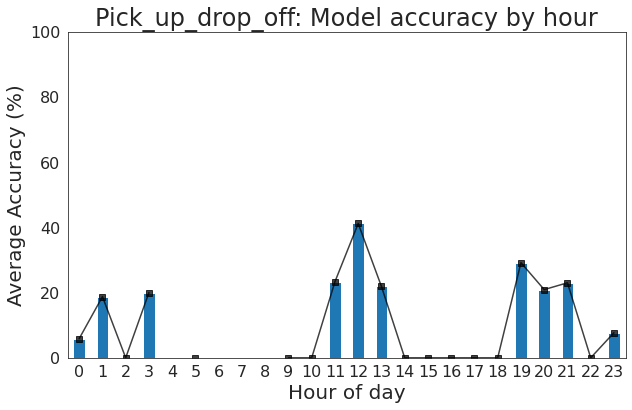

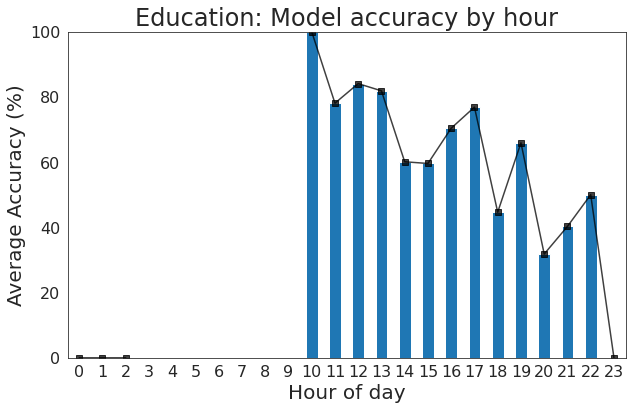

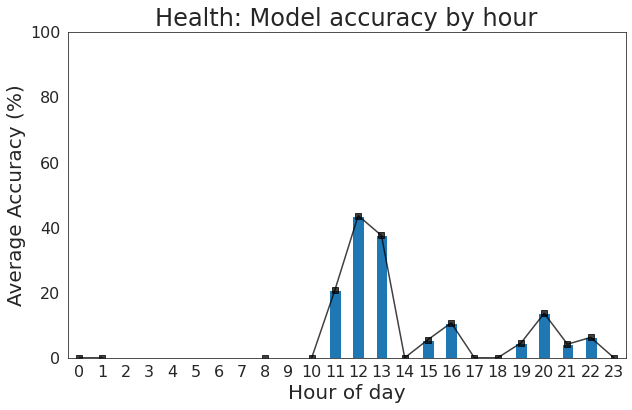

In [107]:
for pur in sorted(predictions_17_gdf['purpose'].unique()):
    plot_title = '%s: Model accuracy by hour' % (PURPOSE_CLASSES[pur].capitalize())
    ax = average_accuracy_by_hour(predictions_17_gdf, plot_title=plot_title, purposes=[pur])
    plt.show()

##### Interpretation:
    o 
    o 

### 5.1.3 Weekend vs Weekday errors

## 5.2 Calendar plot

In [108]:
def create_data_calendar(data, agg={'id_trip':'count'}):
    data = data.set_index('endtime').groupby([pd.Grouper(freq='1h')]).agg(agg)
    
    min_date = data.index.min().strftime('%Y–%m-%d')
    max_date = data.index.max() - datetime.timedelta(days=1)
    max_date = max_date.strftime('%Y–%m-%d')
    first_col = data.columns[0]
    data_per_hour = pd.concat([data[data.index.hour == x].reset_index()[first_col] for x in range(0,24)], axis=1).T
    data_per_hour.index = np.arange(0,24)

    data_per_hour.columns = [str(dt.date()) for dt in pd.date_range('2017-09-18', '2017-10-17', freq='D')]
    
    return data_per_hour


def plot_calendar(data, percentage_plot=False):
    fig, ax = plt.subplots(1, figsize=(14,6))
    if percentage_plot:
        sns.heatmap(data.T,ax=ax, linewidths=.1, annot=True, fmt='.1f',\
                    cbar_kws={'label': '% trips', "orientation": "vertical"}, cmap=COLOUR_MAP);
    else:
        sns.heatmap(data.T,ax=ax, linewidths=.1, annot=True, fmt='.0f',\
                    cbar_kws={'label': 'Count of trips', "orientation": "vertical"}, cmap=COLOUR_MAP);
    ax.set_xticklabels(labels=np.arange(0,24),rotation=0);
    ax.figure.axes[-1].yaxis.label.set_size(16)
    plt.xticks(size=12)
    plt.xlabel("Hour of Day", size=16)
    plt.ylabel("Date", size=16)
    return ax

In [109]:
all_calendar = create_data_calendar(predictions_17_gdf, agg={'id_trip':'count'})

In [110]:
all_calendar.head()

2017-09-18  2017-09-19  2017-09-20  2017-09-21  2017-09-22  2017-09-23  \
0         1.0         3.0         2.0         4.0         8.0         7.0   
1         0.0         2.0         2.0         3.0         2.0         3.0   
2         0.0         1.0         1.0         2.0         0.0         3.0   
3         0.0         1.0         0.0         0.0         2.0         1.0   
4         0.0         0.0         0.0         0.0         2.0         2.0   

   2017-09-24  2017-09-25  2017-09-26  2017-09-27  ...  2017-10-08  \
0         4.0        11.0        13.0         8.0  ...         6.0   
1         4.0         8.0         8.0         4.0  ...         6.0   
2         0.0         1.0         5.0         1.0  ...         5.0   
3         0.0         1.0         2.0         2.0  ...         4.0   
4         0.0         1.0         1.0         1.0  ...         1.0   

   2017-10-09  2017-10-10  2017-10-11  2017-10-12  2017-10-13  2017-10-14  \
0         9.0        12.0         7.0         6.0         7.0         7.0   
1         2.0         4.0         6.0         7.0        10.0        11.0   
2         1.0         3.0         2.0         6.0        12.0         3.0   
3         1.0         0.0         0.0         4.0         1.0         3.0   
4         0.0         2.0         0.0         1.0         2.0         7.0   

   2017-10-15  2017-10-16  2017-10-17  
0         4.0         7.0         1.0  
1         0.0         3.0         NaN  
2         1.0         3.0         NaN  
3         2.0         2.0         NaN  
4         0.0         0.0         NaN  

[5 rows x 30 columns]

In [111]:
len(predictions_17_gdf)

5737

<AxesSubplot:xlabel='Hour of Day', ylabel='Date'>

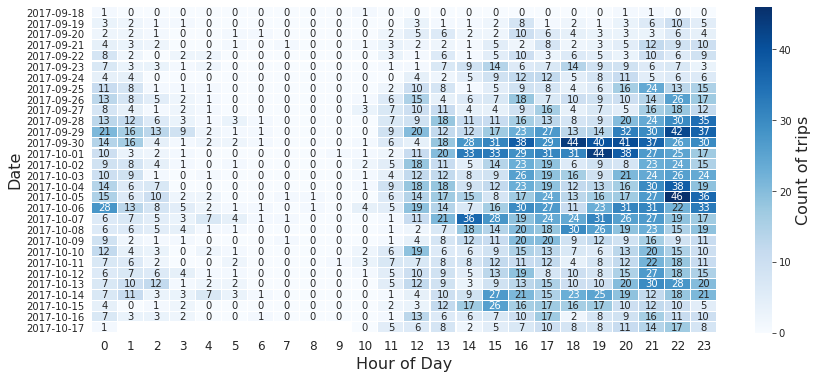

In [112]:
plot_calendar(all_calendar)

In [113]:
perc_correct_calendar = create_data_calendar(predictions_17_gdf, agg={'correct':'mean'}) * 100
perc_correct_calendar = perc_correct_calendar.fillna(0.0)

<AxesSubplot:xlabel='Hour of Day', ylabel='Date'>

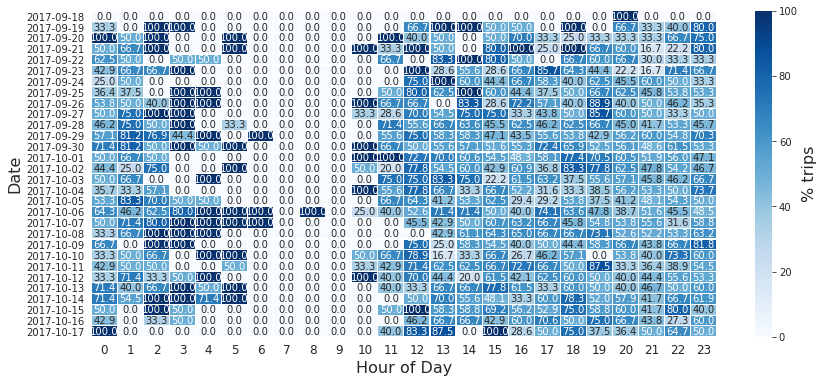

In [114]:
plot_calendar(perc_correct_calendar, percentage_plot=True)

##### Interpretatation
    o 
    o 

## 5.4. Temporal decomposition  

In [115]:
# use the function defined above to calculate the proportion of correct trips of each class per hour
frequency = '1h' # One day
correct_predictions_by_hour = group_time_data_by_purpose(correct_predictions_per_timestamp,
                                                        frequency=frequency, purposes=[0,1,2,3,4,5])

In [123]:
correct_predictions_by_hour.fillna(0, inplace=True)

In [132]:
res = statsmodels.tsa.seasonal.seasonal_decompose(correct_predictions_by_hour, period=24)


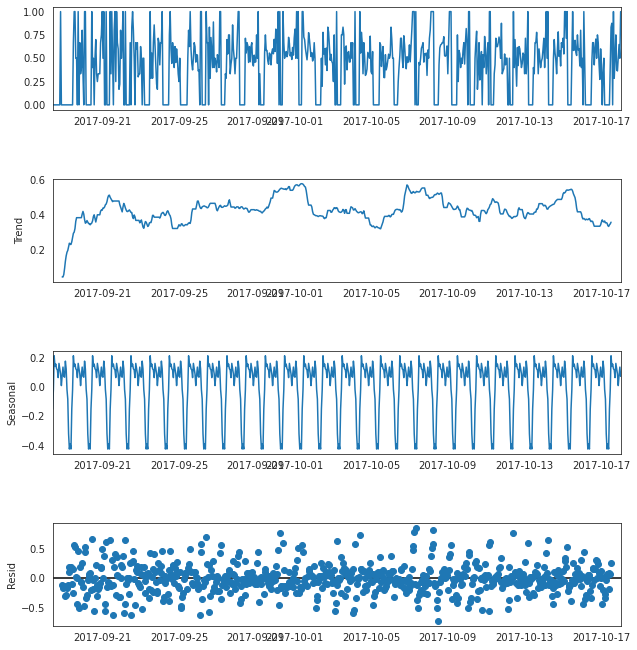

In [133]:
ax = res.plot()
fig = plt.gcf()
fig.set_figheight(10)
fig.set_figwidth(10)
plt.show()

By purpose

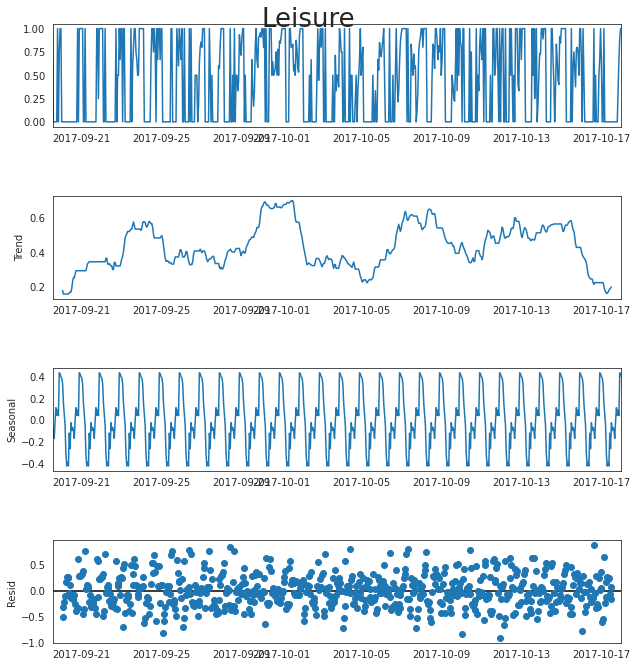

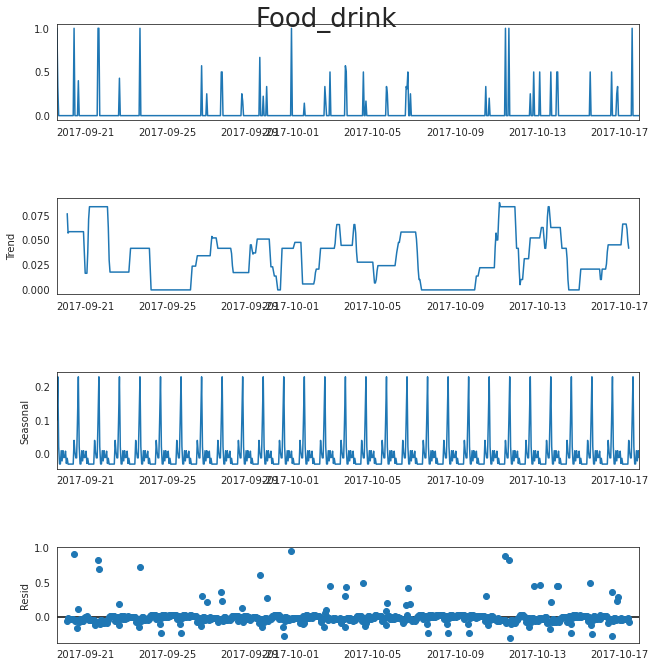

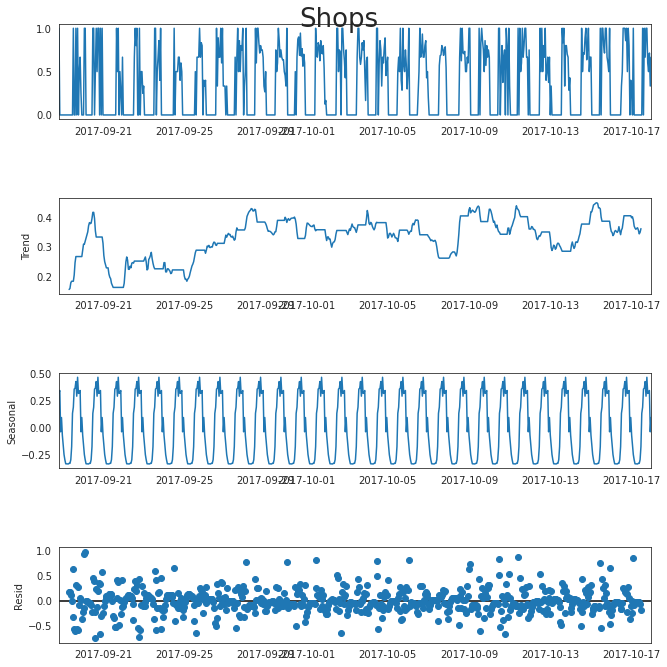

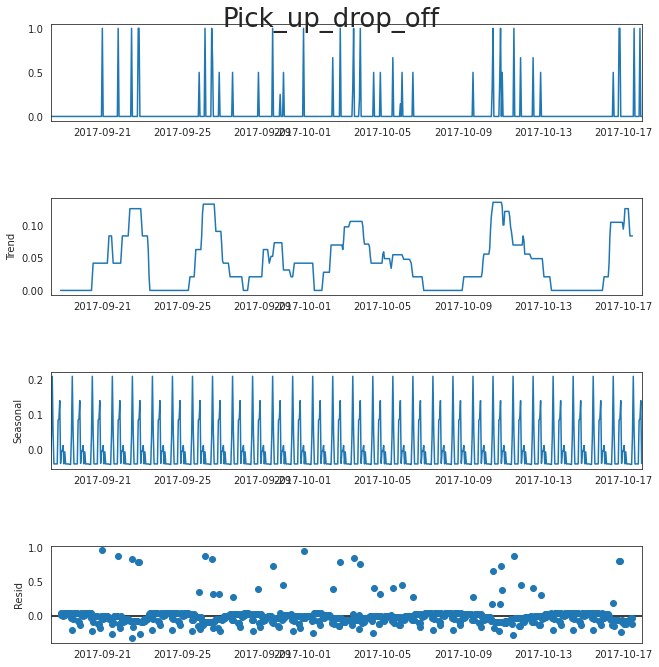

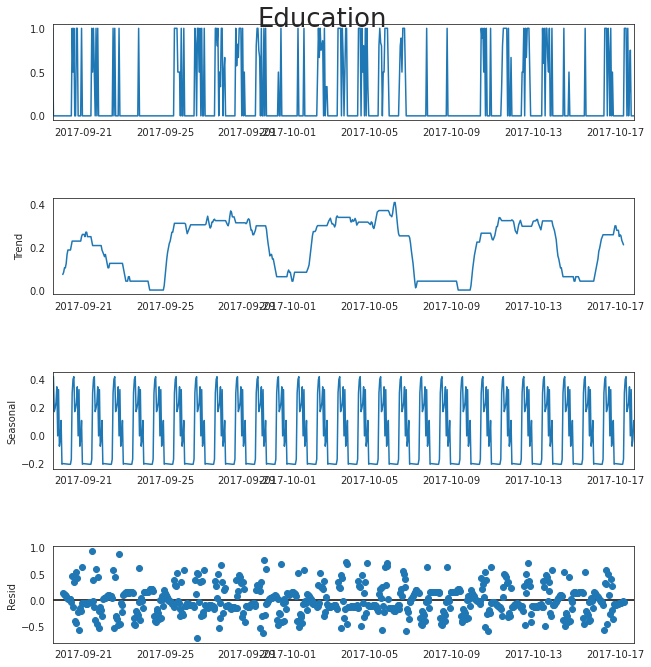

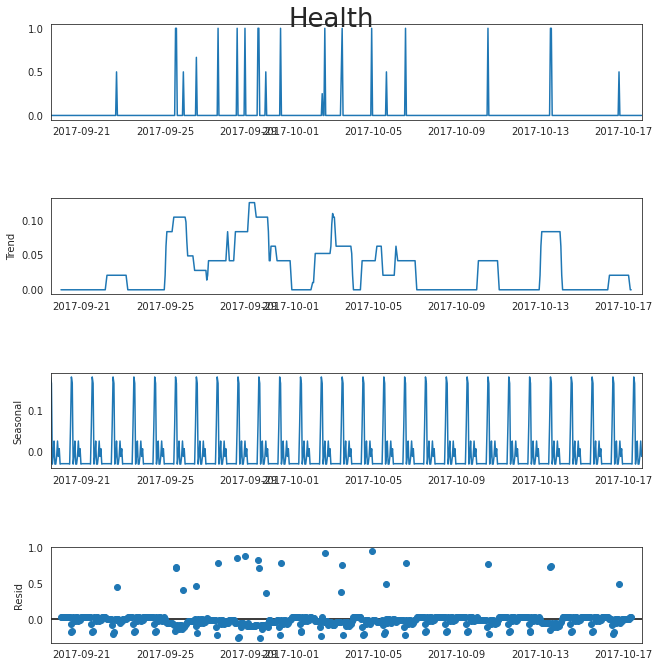

In [134]:
frequency = '1h' # One day
period = 24
for pur in sorted(predictions_17_gdf['prediction'].unique()):
    data = group_time_data_by_purpose(correct_predictions_per_timestamp,
                                                        frequency=frequency, purposes=[pur])
    
    data = data.fillna(0.0)
    plot_title = PURPOSE_CLASSES[pur].capitalize()
    res = statsmodels.tsa.seasonal.seasonal_decompose(data, period=period)
    ax = res.plot()
    fig = plt.gcf()
    fig.set_figheight(10)
    fig.set_figwidth(10)
    plt.suptitle(plot_title, size=26)
    plt.show()

## 5.5. Augmented Dickey-Fuller (ADF) test  

In [135]:
help(statsmodels.tsa.stattools.adfuller)

Help on function adfuller in module statsmodels.tsa.stattools:

adfuller(x, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)
    Augmented Dickey-Fuller unit root test.
    
    The Augmented Dickey-Fuller test can be used to test for a unit root in a
    univariate process in the presence of serial correlation.
    
    Parameters
    ----------
    x : array_like, 1d
        The data series to test.
    maxlag : int
        Maximum lag which is included in test, default 12*(nobs/100)^{1/4}.
    regression : {"c","ct","ctt","nc"}
        Constant and trend order to include in regression.
    
        * "c" : constant only (default).
        * "ct" : constant and trend.
        * "ctt" : constant, and linear and quadratic trend.
        * "nc" : no constant, no trend.
    
    autolag : {"AIC", "BIC", "t-stat", None}
        Method to use when automatically determining the lag.
    
        * if None, then maxlag lags are used.
        * if "AIC" (default) or 

<AxesSubplot:xlabel='endtime'>

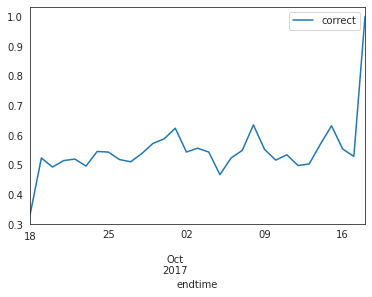

In [136]:
correct_predictions_by_day.plot()

In [137]:
adf = statsmodels.tsa.stattools.adfuller(correct_predictions_by_day['correct'])
print('ADF Statistic: %f' % adf[0], 'p-value: %f' % adf[1])

ADF Statistic: -2.497793 p-value: 0.116012


by purpose

In [138]:
frequency = '1d' # One day
for pur in sorted(predictions_17_gdf['prediction'].unique()):
    data = group_time_data_by_purpose(correct_predictions_per_timestamp,
                                                        frequency=frequency, purposes=[pur])
    data = data.fillna(0.0)
    adf = statsmodels.tsa.stattools.adfuller(data['correct'])
    print(PURPOSE_CLASSES[pur].capitalize(), 'ADF Statistic: %f' % adf[0], 'p-value: %f' % adf[1])
    print('-'*50)

Leisure ADF Statistic: -3.531695 p-value: 0.007209
--------------------------------------------------
Food_drink ADF Statistic: -3.994168 p-value: 0.001441
--------------------------------------------------
Shops ADF Statistic: -7.553853 p-value: 0.000000
--------------------------------------------------
Pick_up_drop_off ADF Statistic: -4.696650 p-value: 0.000085
--------------------------------------------------
Education ADF Statistic: -5.374832 p-value: 0.000004
--------------------------------------------------
Health ADF Statistic: -1.266276 p-value: 0.644457
--------------------------------------------------


# Extra

## Area under the precision-recall curve
The area under the precision-recall curve (AUPRC) is another performance metric that you can use to evaluate a classification model. If your model achieves a perfect AUPRC, it means your model can find all of the positive samples (perfect recall) without accidentally marking any negative samples as positive (perfect precision.) 

`auprc = sklearn.metrics.average_precision_score(true_labels, predicted_labels)`